✅ 현재 구조 요약
**사용자가 입력한 데이터 (user_data)**를 기반으로,

**3가지 질병 (당뇨병, 고혈압, 비만)**에 대한 예측 결과를 동시에 보여주고,

각 예측 결과에 대해:

예측 클래스 (정상, 주의, 고위험 등)

예측 확률

대표 feature 값 (HE_glu, HE_sbp2, BMI_calculated)

해당 값의 상태 분류 (정상/주의/고위험)

참고 범위

해석을 함께 출력합니다.

이후 **군집화(클러스터링)**를 통해 사용자 건강 특성을 분류하고자 합니다.

✅ 정리된 목표
목표	설명
1. 예측 결과 보고서 생성	각 질병에 대해 사용자 상태, 예측 결과, 주요 변수 해석 출력
2. 상태 분류 기준 정리	대표 feature에 대한 분류 기준(정상/주의/고위험)을 기반으로 상태 자동 판별
3. 군집화 준비	예측 결과를 바탕으로 군집화에 활용할 health profile 생성
4. 가중치 기반 군집화 (선택)	세 질병 중 어떤 질병 위험이 높은지에 따라 가중치 반영 가능

✅ 1. 상태 분류 기준 함수 (자동 분류용)
이 기준을 코드화하면 다음과 같이 사용할 수 있습니다:

def classify_feature_status(feature_name, user_value):
    if feature_name == "HE_sbp2":
        if user_value <= 120:
            return "정상", "90 ~ 120", "121 ~ 139"
        elif 121 <= user_value <= 139:
            return "주의", "90 ~ 120", "121 ~ 139"
        else:
            return "고위험", "90 ~ 120", "121 ~ 139"

    elif feature_name == "HE_glu":
        if user_value <= 99:
            return "정상", "70 ~ 99", "100 ~ 125"
        elif 100 <= user_value <= 125:
            return "주의", "70 ~ 99", "100 ~ 125"
        else:
            return "고위험", "70 ~ 99", "100 ~ 125"

    elif feature_name == "BMI_calculated":
        if user_value < 18.5:
            return "낮은 신체", "18.5 ~ 22.9", "23.0 ~ 24.9 이상"
        elif 18.5 <= user_value <= 22.9:
            return "정상", "18.5 ~ 22.9", "23.0 ~ 24.9 이상"
        elif 23.0 <= user_value <= 24.9:
            return "과체중", "18.5 ~ 22.9", "23.0 ~ 24.9 이상"
        else:
            return "비만", "18.5 ~ 22.9", "23.0 ~ 24.9 이상"
    else:
        return "Unknown", "-", "-"


✅ 2. 예측 결과를 종합해 리포트 생성
위 함수를 활용하여 generate_disease_report() 내부를 아래처럼 확장하면 됩니다:


def generate_disease_report(user_name, disease_name, result, top_feature_name, user_value):
    status, normal_range, caution_range = classify_feature_status(top_feature_name, user_value)

    print(f"=== {disease_name} 예측 결과 ===")
    print(f"1. {user_name}, 건강은 {disease_name} 위험군입니다.")
    print(f"2. 건강 점수: {float(result['probabilities'][result['predicted_class'] - 1]) * 100:.1f}점 (예측 확률: {float(result['probabilities'][result['predicted_class'] - 1]) * 100:.1f}%)")
    print(f"   예측 결과: {result['class_name']} ({result['predicted_class']}등급)")
    print(f"   설명: {result['explanation']}")
    print(f"3. {top_feature_name} 값: {user_value} → 상태: {status}")
    print(f"   정상 기준: {normal_range}, 주의 기준: {caution_range}")
    print(f"   이 수치가 증가하면 {disease_name} 위험이 증가합니다.\n")


✅ 3. 군집화 준비 (예측 결과 기반 feature vector 생성)
군집화를 하려면 예측 결과를 다음과 같이 정량화해야 합니다:

cluster_vector = {
    "당뇨병_등급": result_dm['predicted_class'],  # 1~3
    "고혈압_등급": result_hp['predicted_class'],  # 1~4
    "비만_등급": result_obesity['predicted_class']  # 1~6
}

# 또는 상태를 one-hot 인코딩할 수도 있음
그 후, 여러 사용자의 cluster_vector를 기반으로 KMeans, DBSCAN, HDBSCAN 등의 군집화를 진행할 수 있습니다.


✅ 4. (선택) 가중치 기반 클러스터링
당뇨병 위험을 더 중요하게 보고 싶다면, 예를 들어:

cluster_vector_weighted = {
    "당뇨병_등급": result_dm['predicted_class'] * 2.0,  # 더 중요한 위험요소
    "고혈압_등급": result_hp['predicted_class'] * 1.0,
    "비만_등급": result_obesity['predicted_class'] * 1.2
}
이렇게 비율 조절도 가능합니다.


✅ 전체 구조도 예시
css
복사
편집
[사용자 입력]
      ↓
[예측 모델 (3가지)]
      ↓
[대표 변수 기준 상태 분류]
      ↓
[사용자 리포트 생성]
      ↓
[예측 결과 기반 벡터 생성]
      ↓
[사용자 군집화]
🔚 마무리 제안
리포트 출력은 위 구조를 함수화해서 자동화

top_feature_name, user_value는 매핑으로 자동 추출

군집화는 predicted_class들을 기준으로 벡터 만들고 KMeans 등 적용

In [1]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [2]:
#data=pd.read_csv("C:/건강검진/health_checkup/JDM/Real/군집화_전처리.csv")
data=pd.read_csv("C:/KJY/health_checkup/KJY/real 군집화/processed_dataset_real2.csv")

In [6]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

# 피처 정의 (HE_HP와 HE_DM_HbA1c 결합)
HE_HP_input_features = ['HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'age', 'sex']
HE_DM_HbA1c_input_features = ['HE_glu', 'HE_wc', 'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'age', 'sex'] 
HE_obe_input_features= [ 'HE_wc', 'HE_wt','HE_sbp1', 'HE_ht', 'HE_dbp1',  'HE_glu', 'HE_crea', 'HE_TG', 'HE_HDL_st2','age','sex']

# 데이터 로드
data=pd.read_csv("C:/KJY/health_checkup/KJY/real 군집화/processed_dataset_real2.csv")

# HE_HP 데이터 처리
X_hp = data[HE_HP_input_features]
y_hp = data['HE_HP'].astype(int) - 1

# HE_DM_HbA1c 데이터 처리
X_dm = data[HE_DM_HbA1c_input_features]
y_dm = data['HE_DM_HbA1c'].astype(int) - 1

# HE_obe 데이터 처리
X_obe = data[HE_obe_input_features].copy()
y_obe = data['HE_obe'].astype(int) - 1



# 훈련/테스트 분할 (HE_HP)
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_hp, y_hp, stratify=y_hp, test_size=0.2, random_state=42)

# 훈련/테스트 분할 (HE_DM_HbA1c)
X_train_dm, X_test_dm, y_train_dm, y_test_dm = train_test_split(X_dm, y_dm, stratify=y_dm, test_size=0.2, random_state=42)

# 훈련/테스트 분할 (HE_obe)
X_train_obe, X_test_obe, y_train_obe, y_test_obe = train_test_split(X_obe, y_obe, stratify=y_obe, test_size=0.2, random_state=42)

# 스케일링 (HE_HP)
scaler_hp = StandardScaler()
X_train_hp_scaled = scaler_hp.fit_transform(X_train_hp)
X_test_hp_scaled = scaler_hp.transform(X_test_hp)

# 스케일링 (HE_DM_HbA1c)
scaler_dm = StandardScaler()
X_train_dm_scaled = scaler_dm.fit_transform(X_train_dm)
X_test_dm_scaled = scaler_dm.transform(X_test_dm)

# 스케일링 (HE_obe)
scaler_obe = StandardScaler()
X_train_obe_scaled = scaler_obe.fit_transform(X_train_obe)
X_test_obe_scaled = scaler_obe.transform(X_test_obe)

# SMOTE 적용 (HE_HP)
smote_hp = SMOTE(random_state=42)
X_train_hp_smote, y_train_hp_smote = smote_hp.fit_resample(X_train_hp_scaled, y_train_hp)

# SMOTE 적용 (HE_DM_HbA1c)
smote_dm = SMOTE(random_state=42)
X_train_dm_smote, y_train_dm_smote = smote_dm.fit_resample(X_train_dm_scaled, y_train_dm)

# SMOTE 적용 (HE_obe)
smote_obe = SMOTE(random_state=42)
X_train_obe_smote, y_train_obe_smote = smote_obe.fit_resample(X_train_obe_scaled, y_train_obe)

# 모델 정의 (HistGradientBoostingClassifier)
base_model_hp = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    max_depth=5,
    min_samples_leaf=20,
    l2_regularization=1.0,
    random_state=0
)

base_model_dm = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    max_depth=5,
    min_samples_leaf=20,
    l2_regularization=1.0,
    random_state=0
)

base_model_obe = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=50,
    max_depth=5,
    min_samples_leaf=20,
    l2_regularization=1.0,
    random_state=0
)

#모델 훈련
#(HE_HP)
model_hp = CalibratedClassifierCV(base_model_hp, method='sigmoid', cv=5)
model_hp.fit(X_train_hp_smote, y_train_hp_smote)

#(HE_DM_HbA1c)
model_dm = CalibratedClassifierCV(base_model_dm, method='sigmoid', cv=5)
model_dm.fit(X_train_dm_smote, y_train_dm_smote)

#(HE-obe)
model_obe = CalibratedClassifierCV(base_model_obe, method='sigmoid', cv=5)
model_obe.fit(X_train_obe_smote, y_train_obe_smote)


#테스트 데이터 평가
#(HE_HP)
y_pred_hp = model_hp.predict(X_test_hp_scaled)
print("HE_HP Classification Report:")
print(classification_report(y_test_hp, y_pred_hp, target_names=['Normal', 'Pre-hp', 'Pre-high-hp', 'High-hp']))
#(HE_DM_HbA1c)
y_pred_dm = model_dm.predict(X_test_dm_scaled)
print("HE_DM_HbA1c Classification Report:")
print(classification_report(y_test_dm, y_pred_dm, target_names=['Class 0 (Normal)', 'Class 1 (Intermediate)', 'Class 2 (Diabetes)']))
#(HE_obe)
y_pred_obe = model_obe.predict(X_test_obe_scaled)
print("HE_obe Classification Report:")
print(classification_report(y_test_obe, y_pred_obe, target_names=['Low', 'Normal', 'Pre-obese', 'Obese1', 'Obese2', 'Obese3']))


# 모델 저장 
#(HE_HP)
calibrated_filename_hp = "For_HE_HP_calibrated_real.pkl"
joblib.dump(model_hp, calibrated_filename_hp)
print(f"HE_HP 모델이 '{calibrated_filename_hp}' 파일로 저장되었습니다.")
#(HE_DM_HbA1c)
calibrated_filename_dm = "For_HE_DM_HbA1c_calibrated_real.pkl"
joblib.dump(model_dm, calibrated_filename_dm)
print(f"HE_DM_HbA1c 모델이 '{calibrated_filename_dm}' 파일로 저장되었습니다.")
#(HE_obe)
calibrated_filename_obe = "For_HE_obe_calibrated_real.pkl"
joblib.dump(model_obe, calibrated_filename_obe)
print(f"HE_DM_HbA1c 모델이 '{calibrated_filename_obe}' 파일로 저장되었습니다.")


# 전처리 객체 저장 
#(HE_HP)
scaler_filename_hp = "HE_HP_scaler_real.pkl"
joblib.dump(scaler_hp, scaler_filename_hp)
print(f"HE_HP 스케일러가 '{scaler_filename_hp}' 파일로 저장되었습니다.")
#(HE_DM_HbA1c)
scaler_filename_dm = "HE_DM_HbA1c_scaler_real.pkl"
joblib.dump(scaler_dm, scaler_filename_dm)
print(f"HE_DM_HbA1c 스케일러가 '{scaler_filename_dm}' 파일로 저장되었습니다.")
#(HE_obe)
scaler_filename_obe = "HE_obe_scaler_real.pkl"
joblib.dump(scaler_obe, scaler_filename_obe)
print(f"HE_DM_HbA1c 스케일러가 '{scaler_filename_obe}' 파일로 저장되었습니다.")


# 피처 목록 저장 
#(HE_HP)
features_filename_hp = "HE_HP_input_features_list_real.pkl"
joblib.dump(HE_HP_input_features, features_filename_hp)
print(f"HE_HP 피처 목록이 '{features_filename_hp}' 파일로 저장되었습니다.")
#(HE_DM_HbA1c)
features_filename_dm = "HE_DM_HbA1c_input_features_list_real.pkl"
joblib.dump(HE_DM_HbA1c_input_features, features_filename_dm)
print(f"HE_DM_HbA1c 피처 목록이 '{features_filename_dm}' 파일로 저장되었습니다.")
#(HE_obe)
features_filename_obe = "HE_obe_input_features_list_real.pkl"
joblib.dump(HE_obe_input_features, features_filename_obe)
print(f"HE_DM_HbA1c 피처 목록이 '{features_filename_obe}' 파일로 저장되었습니다.")


# 훈련 데이터 평균값 저장
# (HE_HP)
train_filename_hp = "train_means_hp_real.pkl"
joblib.dump(X_train_hp.mean(), train_filename_hp)
print(f"HE_HP 훈련 데이터 평균값이 '{train_filename_hp}' 파일로 저장되었습니다.")
#(HE_DM_HbA1c)
train_filename_dm = "train_means_dm_real.pkl"
joblib.dump(X_train_dm.mean(), train_filename_dm)
print(f"HE_DM_HbA1c 훈련 데이터 평균값이 '{train_filename_dm}' 파일로 저장되었습니다.")
#(HE_obe)
train_filename_obe = "train_means_obe_real.pkl"
joblib.dump(X_train_dm.mean(), train_filename_obe)
print(f"HE_obe 훈련 데이터 평균값이 '{train_filename_obe}' 파일로 저장되었습니다.")


c:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

HE_HP Classification Report:
              precision    recall  f1-score   support

      Normal       0.80      0.77      0.78       619
      Pre-hp       0.26      0.42      0.32       106
 Pre-high-hp       0.46      0.53      0.49       190
     High-hp       0.71      0.59      0.65       471

    accuracy                           0.65      1386
   macro avg       0.56      0.58      0.56      1386
weighted avg       0.68      0.65      0.66      1386

HE_DM_HbA1c Classification Report:
                        precision    recall  f1-score   support

      Class 0 (Normal)       0.84      0.87      0.85       770
Class 1 (Intermediate)       0.72      0.62      0.67       402
    Class 2 (Diabetes)       0.63      0.71      0.67       214

              accuracy                           0.77      1386
             macro avg       0.73      0.73      0.73      1386
          weighted avg       0.77      0.77      0.77      1386

HE_obe Classification Report:
              precis

In [10]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

# 사용자 입력 처리 함수
def process_user_input(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)  # 누락된 피처를 평균값으로 채움
    user_scaled = scaler.transform(user_df)
    return user_df, user_scaled

# 예측 함수
def predict_disease_probabilities(user_scaled, model, stages, class_explanations):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    stage = stages.get(stage_index, "Unknown")
    explanation = class_explanations.get(stage_index, "No explanation available.")
    class_probs_formatted = [f"{probs[i]:.2f}" for i in range(len(probs))]
    return {
        "probabilities": class_probs_formatted,
        "predicted_class": stage_index + 1,
        "class_name": stage,
        "explanation": explanation
    }

# 각 클래스의 설명
diabetes_class_explanations = {
    0: "Normal: 혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
    1: "Pre-diabetes: 혈당이 정상보다 높은 수준이지만 당뇨병에는 이르지 않았습니다. 생활습관 개선이 필요합니다.",
    2: "Diabetes: 당뇨병으로 진단되었습니다. 전문가와 상담이 필요합니다."
}

hypertension_class_explanations = {
    0: "Normal: 혈압이 정상 범위에 있습니다.",
    1: "Pre-hypertension: 혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
    2: "Hypertension Stage 1: 고혈압 전단계로, 생활습관 개선과 치료가 필요할 수 있습니다.",
    3: "Hypertension Stage 2: 고혈압, 전문가의 진단과 치료가 필요합니다."
}

obesity_class_explanations = {
    0: "Underweight: 저체중입니다. 체중 증가가 필요할 수 있습니다.",
    1: "Normal: 정상 체중입니다. 유지 관리가 필요합니다.",
    2: "Overweight: 과체중입니다. 체중 감량을 고려할 수 있습니다.",
    3: "Obese: 비만입니다. 체중 감량과 건강 관리가 필요합니다.",
    4: "Severely Obese: 심각한 비만입니다. 전문가의 진단과 관리가 필요합니다.",
    5: "Morbidly Obese: 병적 비만입니다. 전문가의 도움을 받아야 합니다."
}

# 사용자 입력 예시
user_data = {
    'HE_glu': 130.0,       # 공복 혈당 126 이상 -> 당뇨병 확진
    'HE_HbA1c': 7.0,       # HbA1c 6.5% 이상 -> 당뇨병 확진
    'HE_ht': 170, 
    'HE_wt': 80, 
    'HE_wc': 100, 
    'HE_BMI': 28,
    'HE_sbp1': 140, 
    'HE_dbp1': 85,
    'HE_sbp2': 130, 
    'HE_dbp2': 80,
    'HE_Upro': 7,
    'HE_chol': 220, 
    'HE_HDL_st2': 50,
    'HE_TG': 150, 
    'HE_LDL_drct': 130, 
    'HE_crea': 0.8, 
    'HE_ast': 20, 
    'HE_alt': 15,
    'LS_FRUOT': 4
}

# 모델, 스케일러, 피처, 평균값 로드
model_dm = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
scaler_dm = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
features_dm = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
train_means_dm = joblib.load('train_means_dm_real.pkl')

model_hp = joblib.load('For_HE_HP_calibrated_real.pkl')
scaler_hp = joblib.load('HE_HP_scaler_real.pkl')
features_hp = joblib.load('HE_HP_input_features_list_real.pkl')
train_means_hp = joblib.load('train_means_hp_real.pkl')

model_obesity = joblib.load('For_HE_obe_calibrated_real.pkl')
scaler_obesity = joblib.load('HE_obe_scaler_real.pkl')
features_obesity = joblib.load('HE_obe_input_features_list_real.pkl')
train_means_obesity = joblib.load('train_means_obe_real.pkl')



# 사용자 입력 처리 및 예측
user_df_dm, user_scaled_dm = process_user_input(user_data, features_dm, scaler_dm, train_means_dm)
user_df_hp, user_scaled_hp = process_user_input(user_data, features_hp, scaler_hp, train_means_hp)
user_df_obesity, user_scaled_obesity = process_user_input(user_data, features_obesity, scaler_obesity, train_means_obesity)

# 당뇨병 예측
diabetes_stages = {0: "Normal", 1: "Pre-diabetes", 2: "Diabetes"}
result_dm = predict_disease_probabilities(user_scaled_dm, model_dm, diabetes_stages, diabetes_class_explanations)

# 고혈압 예측
hypertension_stages = {0: "Normal", 1: "Pre-hypertension", 2: "Hypertension Stage 1", 3: "Hypertension Stage 2"}
result_hp = predict_disease_probabilities(user_scaled_hp, model_hp, hypertension_stages, hypertension_class_explanations)

# 비만도 예측
obesity_stages = {0: "Underweight", 1: "Normal", 2: "Overweight", 3: "Obese", 4: "Severely Obese", 5: "Morbidly Obese"}
result_obesity = predict_disease_probabilities(user_scaled_obesity, model_obesity, obesity_stages, obesity_class_explanations)


def generate_disease_report(user_name, disease_name, result, top_feature_name, user_value):
    # 건강 점수 계산
    prob_percent = float(result['probabilities'][result['predicted_class'] - 1]) * 100
    health_score = round(prob_percent, 1)

    # 변수 이름 매핑 (설명 추가)
    feature_label_map = {
        "HE_sbp1": "HE_sbp1 (수축기 혈압)",
        "HE_glu": "HE_glu (공복혈당)",
        "HE_BMI": "HE_BMI(BMI)"
    }
    feature_label = feature_label_map.get(top_feature_name, top_feature_name)

    # 기준 범위 설정
    if top_feature_name == "HE_sbp1":
        if user_value <= 120:
            status = "정상"
        elif 121 <= user_value <= 139:
            status = "주의"
        else:
            status = "고위험"
        normal = "90~120"
        warning = "121~139"
    elif top_feature_name == "HE_glu":
        if user_value <= 99:
            status = "정상"
        elif 100 <= user_value <= 125:
            status = "주의"
        else:
            status = "고위험"
        normal = "70~99"
        warning = "100~125"
    elif top_feature_name == "HE_BMI":
        if user_value < 18.5:
            status = "저체중"
        elif 18.5 <= user_value <= 22.9:
            status = "정상"
        elif 23.0 <= user_value <= 24.9:
            status = "과체중"
        else:
            status = "비만"
        normal = "18.5~22.9"
        warning = "23.0~24.9 이상"
    else:
        status = "알 수 없음"
        normal = "-"
        warning = "-"

    # 출력
    print(f"=== {disease_name} 예측 결과 ===")
    print(f"1. {user_name}님, 건강은 {disease_name} 위험이 있습니다.\n")
    print(f"2. 건강 점수: {health_score:.1f}점 (예측 확률: {prob_percent:.1f}%)")
    print(f"예측 결과: {result['class_name']} (클래스 {result['predicted_class']})")
    print(f"설명: {result['explanation']}\n")

    print(f"3. {feature_label} 수치: {user_value} → 상태: {status}")
    print(f"정상 기준: {normal}, 주의 기준: {warning}")
    print(f"이 수치가 높아지면 {disease_name} 위험이 증가합니다.\n")

# 대표 feature 맵
top_features = {
    "당뇨병": "HE_glu",
    "고혈압": "HE_sbp1",
    "비만": "HE_BMI"
}


# 질병별 결과를 묶기
disease_results = {
    "당뇨병": result_dm,
    "고혈압": result_hp,
    "비만": result_obesity
}

# 자동 리포트 출력
for disease_name, result in disease_results.items():
    top_feature = top_features[disease_name]
    user_value = user_data.get(top_feature, None)

    if user_value is not None:
        generate_disease_report(
            user_name="홍길동",
            disease_name=disease_name,
            result=result,
            top_feature_name=top_feature,
            user_value=user_value
        )
    else:
        print(f"{disease_name}에 대한 {top_feature} 값이 user_data에 없습니다.")





=== 당뇨병 예측 결과 ===
1. 홍길동님, 건강은 당뇨병 위험이 있습니다.

2. 건강 점수: 96.0점 (예측 확률: 96.0%)
예측 결과: Diabetes (클래스 3)
설명: Diabetes: 당뇨병으로 진단되었습니다. 전문가와 상담이 필요합니다.

3. HE_glu (공복혈당) 수치: 130.0 → 상태: 고위험
정상 기준: 70~99, 주의 기준: 100~125
이 수치가 높아지면 당뇨병 위험이 증가합니다.

=== 고혈압 예측 결과 ===
1. 홍길동님, 건강은 고혈압 위험이 있습니다.

2. 건강 점수: 65.0점 (예측 확률: 65.0%)
예측 결과: Hypertension Stage 1 (클래스 3)
설명: Hypertension Stage 1: 고혈압 전단계로, 생활습관 개선과 치료가 필요할 수 있습니다.

3. HE_sbp1 (수축기 혈압) 수치: 140 → 상태: 고위험
정상 기준: 90~120, 주의 기준: 121~139
이 수치가 높아지면 고혈압 위험이 증가합니다.

=== 비만 예측 결과 ===
1. 홍길동님, 건강은 비만 위험이 있습니다.

2. 건강 점수: 72.0점 (예측 확률: 72.0%)
예측 결과: Severely Obese (클래스 5)
설명: Severely Obese: 심각한 비만입니다. 전문가의 진단과 관리가 필요합니다.

3. HE_BMI(BMI) 수치: 28 → 상태: 비만
정상 기준: 18.5~22.9, 주의 기준: 23.0~24.9 이상
이 수치가 높아지면 비만 위험이 증가합니다.



위에서 만든 예측 모델 이용하여 벡터화

In [11]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE # 예측 시 필요 없음
# from sklearn.ensemble import HistGradientBoostingClassifier # 모델 파일에 포함되어 로딩됨
# from sklearn.calibration import CalibratedClassifierCV # 모델 파일에 포함되어 로딩됨

# --- 1. 상태 분류 기준 함수 (자동 분류용) ---
# 특정 feature 값의 상태를 분류하고 참고 범위를 반환합니다.
def classify_feature_status(feature_name, user_value):
    """
    대표 feature 값의 상태 (정상/주의/고위험 등)와 참고 범위를 분류합니다.

    Args:
        feature_name (str): 분류할 feature의 이름 ("HE_sbp1", "HE_glu", "HE_BMI").
        user_value (float or int): 사용자의 해당 feature 값.

    Returns:
        tuple: (상태, 정상 기준 범위, 주의/고위험 기준 범위)
               상태는 "정상", "주의", "고위험", "과체중", "비만", "저체중" 등.
               범위는 문자열 형태.
    """
    if feature_name == "HE_sbp1": # 혈압 (수축기)
        if user_value <= 120:
            return "정상", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        elif 121 <= user_value <= 139:
            return "주의", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        else:
            return "고위험", "90 ~ 120 mmHg", "121 ~ 139 mmHg"

    elif feature_name == "HE_glu": # 공복 혈당
        if user_value <= 99:
            return "정상", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        elif 100 <= user_value <= 125:
            return "주의", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        else:
            return "고위험", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"

    elif feature_name == "HE_BMI": # BMI
        if user_value < 18.5:
            return "저체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상" # '낮은 신체' 대신 '저체중' 사용 (사용자 제공 리포트 함수와 통일)
        elif 18.5 <= user_value <= 22.9:
            return "정상", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        elif 23.0 <= user_value <= 24.9:
            return "과체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        else: # user_value >= 25.0
            return "비만", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
    else:
        return "Unknown", "-", "-"

# --- 사용자 입력 데이터 전처리 함수 (제공해주신 코드) ---
def process_user_input(user_data, features, scaler, train_means):
    """
    사용자 입력 데이터를 모델 예측을 위해 전처리합니다.

    Args:
        user_data (dict): 사용자의 원본 입력 데이터.
        features (list): 모델이 학습된 feature 이름 리스트.
        scaler (StandardScaler): 학습 시 사용된 스케일러 객체.
        train_means (dict or Series): 학습 데이터의 feature별 평균값 (누락값 대체용).

    Returns:
        tuple: (전처리된 DataFrame, 스케일링된 numpy 배열)
    """
    # user_data를 DataFrame으로 변환하고, 모델이 기대하는 feature 순서로 재정렬
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    # 누락된 피처를 학습 데이터의 평균값으로 채움
    user_df = user_df.fillna(train_means)
    # 데이터를 스케일링
    user_scaled = scaler.transform(user_df)
    return user_df, user_scaled

# --- 예측 실행 함수 (제공해주신 코드 수정) ---
def predict_disease_probabilities(user_scaled, model, stages, class_explanations):
    """
    스케일링된 사용자 데이터로 질병 예측을 실행하고 결과를 반환합니다.

    Args:
        user_scaled (np.ndarray): 전처리 및 스케일링된 사용자 데이터.
        model (object): 로드된 학습 모델 객체.
        stages (dict): 클래스 인덱스(0부터 시작)를 스테이지 이름(str)으로 매핑.
        class_explanations (dict): 클래스 인덱스(0부터 시작)를 설명(str)으로 매핑.

    Returns:
        dict: 예측 결과 정보 {
            'probabilities': list of float, # 각 클래스에 대한 예측 확률 (float 리스트로 변경)
            'predicted_class': int,       # 예측 등급 (1부터 시작)
            'class_name': str,            # 등급 이름
            'explanation': str,           # 결과 설명
            'predicted_probability': float # 예측된 클래스의 확률 (백분율이 아닌 소수점 형태)
        }
    """
    # 모델의 predict_proba를 사용하여 각 클래스에 대한 확률을 얻음
    probs = model.predict_proba(user_scaled)[0]

    # 가장 높은 확률을 가진 클래스의 인덱스를 찾음 (0부터 시작)
    stage_index = np.argmax(probs)

    # 예측된 클래스 인덱스에 해당하는 스테이지 이름과 설명을 가져옴
    stage = stages.get(stage_index, "Unknown")
    explanation = class_explanations.get(stage_index, "No explanation available.")

    # 결과 딕셔너리 생성
    result = {
        # 확률 리스트를 float 리스트로 반환
        "probabilities": probs.tolist(),
        # 예측 등급은 1부터 시작하도록 +1
        "predicted_class": stage_index + 1,
        "class_name": stage,
        "explanation": explanation,
        # 예측된 클래스의 확률 (float 값)
        "predicted_probability": probs[stage_index]
    }
    return result


# --- 2. 예측 결과를 종합해 리포트 생성 ---
# 예측 결과와 feature 상태 분류를 활용하여 리포트 형식으로 출력하는 함수
# 이전 코드의 generate_disease_report를 기반으로 feature label 추가 및 확률 계산 수정
def generate_disease_report(user_name, disease_name, prediction_result, top_feature_name, user_value):
    """
    단일 질병에 대한 사용자 예측 결과 리포트를 출력합니다.

    Args:
        user_name (str): 사용자의 이름.
        disease_name (str): 질병 이름 ("당뇨병", "고혈압", "비만").
        prediction_result (dict): predict_disease_probabilities 함수에서 반환된 결과.
        top_feature_name (str): 해당 질병의 대표 feature 이름.
        user_value (float or int): 해당 대표 feature의 사용자 값.
    """
    if not prediction_result:
        print(f"=== {disease_name} 예측 결과 ===")
        print("예측 결과를 생성할 수 없습니다.")
        print("-" * 30)
        return

    # 예측 확률을 백분율로 변환 (predict_disease_probabilities에서 already included as predicted_probability)
    prob_percent = prediction_result.get('predicted_probability', 0.0) * 100
    health_score = round(prob_percent, 1)

    # 변수 이름 매핑 (설명 추가)
    feature_label_map = {
        "HE_sbp1": "HE_sbp1 (수축기 혈압)",
        "HE_glu": "HE_glu (공복혈당)",
        "HE_BMI": "HE_BMI (BMI)"
        # 필요한 경우 다른 대표 feature 이름도 추가
    }
    feature_label = feature_label_map.get(top_feature_name, top_feature_name)


    # 대표 feature의 상태 분류 (classify_feature_status 함수 사용)
    status, normal_range, caution_range = classify_feature_status(top_feature_name, user_value)

    # 해석 텍스트 (feature 상태에 기반)
    interpretation = ""
    if status == "정상" or status == "정상 체중":
         interpretation = f"이 수치는 현재 {disease_name}과 관련하여 양호한 상태를 나타냅니다."
    elif status in ["주의", "과체중"]:
         interpretation = f"이 수치는 {disease_name} 위험 증가에 대한 주의가 필요함을 시사합니다."
    elif status in ["고위험", "비만", "경도 비만", "중등도 비만", "고도 비만"]: # 비만 등급 세분화 포함
         interpretation = f"이 수치는 {disease_name} 발생 또는 악화와 밀접한 관련이 있으며, 적극적인 관리가 필요합니다."
    elif status == "저체중": # '낮은 신체' 대신 '저체중' 사용 (classify_feature_status 출력과 통일)
         interpretation = "이 수치는 저체중과 관련 있으며, 건강한 체중 증량 노력이 필요할 수 있습니다."
    else:
         interpretation = "이 수치에 대한 추가 정보가 필요합니다."


    print(f"=== {disease_name} 예측 결과 ===")
    # 예측 결과 설명에 예측 등급 이름과 등급 번호 모두 표시
    print(f"1. {user_name}님의 {disease_name} 위험도는 '{prediction_result['class_name']}' ({prediction_result['predicted_class']}등급)입니다.")

    # 건강 점수 및 예측 확률 출력
    print(f"2. 건강 점수: {health_score:.1f}점 (예측 확률: {prob_percent:.1f}%)")
    # 예측 결과 및 설명 출력 (predicted_disease_probabilities의 explanation 사용)
    print(f"설명: {prediction_result['explanation']}\n") # 한 줄 간격 추가

    # 주요 관련 지표 및 상태 출력
    print(f"3. 주요 관련 지표 ({feature_label}) 수치: {user_value} → 상태: {status}")
    print(f"   정상 기준: {normal_range}, 주의/고위험 기준: {caution_range}")
    # 해석 텍스트 출력
    print(f"   해석: {interpretation}")
    print("-" * 30) # 구분선 추가


# --- 3. 군집화 준비 (예측 결과 기반 feature vector 생성) ---
# 여러 사용자의 예측 결과를 모아 군집화에 사용할 벡터를 생성하는 함수
def create_cluster_vector(result_dm, result_hp, result_obesity):
    """
    세 가지 질병의 예측 등급을 기반으로 사용자 군집화 벡터를 생성합니다.

    Args:
        result_dm (dict): 당뇨병 예측 결과 (predict_disease_probabilities 반환 값).
        result_hp (dict): 고혈압 예측 결과 (predict_disease_probabilities 반환 값).
        result_obesity (dict): 비만 예측 결과 (predict_disease_probabilities 반환 값).

    Returns:
        dict: 군집화에 사용될 feature 벡터 {"당뇨병_등급": int, "고혈압_등급": int, "비만_등급": int}.
              결과가 유효하지 않으면 None 반환.
    """
    # 모든 질병 예측 결과가 유효한지 확인
    if not (result_dm and result_hp and result_obesity):
        print("경고: 모든 예측 결과가 유효하지 않아 군집화 벡터를 생성할 수 없습니다.")
        return None

    cluster_vector = {
        "당뇨병_등급": result_dm.get('predicted_class', 0), # 예측 결과 없으면 0
        "고혈압_등급": result_hp.get('predicted_class', 0),
        "비만_등급": result_obesity.get('predicted_class', 0)
    }
    return cluster_vector

# --- 4. (선택) 가중치 기반 클러스터링을 위한 벡터 생성 ---
def create_weighted_cluster_vector(cluster_vector, weights):
    """
    기본 군집화 벡터에 가중치를 적용하여 새로운 벡터를 생성합니다.

    Args:
        cluster_vector (dict): create_cluster_vector에서 반환된 기본 벡터.
        weights (dict): 각 질병 등급에 적용할 가중치 {"당뇨병_등급": float, ...}.

    Returns:
        dict: 가중치가 적용된 군집화 feature 벡터. 기본 벡터가 유효하지 않으면 None 반환.
    """
    if not cluster_vector:
        return None

    weighted_vector = {}
    for key, value in cluster_vector.items():
        # 가중치가 없으면 기본값 1.0을 사용합니다.
        weighted_vector[key] = value * weights.get(key, 1.0)
    return weighted_vector

# --- 메인 실행 로직 ---
if __name__ == "__main__":

    print("--- 모델 및 데이터 로딩 시작 ---")
    try:
        # 모델, 스케일러, 피처, 평균값 로드 (제공해주신 코드)
        model_dm = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        scaler_dm = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        features_dm = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        train_means_dm = joblib.load('train_means_dm_real.pkl')

        model_hp = joblib.load('For_HE_HP_calibrated_real.pkl')
        scaler_hp = joblib.load('HE_HP_scaler_real.pkl')
        features_hp = joblib.load('HE_HP_input_features_list_real.pkl')
        train_means_hp = joblib.load('train_means_hp_real.pkl')

        model_obesity = joblib.load('For_HE_obe_calibrated_real.pkl')
        scaler_obesity = joblib.load('HE_obe_scaler_real.pkl')
        features_obesity = joblib.load('HE_obe_input_features_list_real.pkl')
        train_means_obesity = joblib.load('train_means_obe_real.pkl')

        print("모델 및 데이터 로딩 성공.")

    except FileNotFoundError as e:
        print(f"오류: 모델 또는 데이터 파일을 찾을 수 없습니다 - {e}")
        print("필요한 .pkl 파일들이 현재 디렉토리에 있는지 확인해주세요.")
        exit() # 파일 없으면 프로그램 종료
    except Exception as e:
        print(f"오류: 모델 로딩 중 예상치 못한 오류 발생 - {e}")
        exit()


    # 각 질병 예측 모델의 클래스(스테이지) 이름과 설명 정의 (제공해주신 코드)
    diabetes_stages = {0: "정상", 1: "주의 필요", 2: "고위험군"} # 이전 simulate와 stage name 통일
    diabetes_class_explanations = {
        0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
        1: "혈당이 정상보다 높은 수준이지만 당뇨병에는 이르지 않았습니다. 생활습관 개선이 필요합니다.",
        2: "당뇨병 고위험군으로 예측됩니다. 전문가와 상담 및 정밀 검사가 필요합니다." # 설명 미세 조정
    }

    hypertension_stages = {0: "정상 혈압", 1: "주의 혈압", 2: "고혈압 1기", 3: "고혈압 2기"} # 이전 simulate와 stage name 통일
    hypertension_class_explanations = {
        0: "혈압이 정상 범위에 있습니다. 건강한 생활 습관을 유지하세요.", # 설명 미세 조정
        1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
        2: "고혈압 1기 단계로 진단될 수 있는 혈압입니다. 의료 전문가와 상담이 필요합니다.", # 설명 미세 조정
        3: "혈압이 매우 높아 고혈압 2기 단계로 진단될 수 있습니다. 즉각적인 전문가의 진단과 치료가 필요합니다." # 설명 미세 조정
    }

    # 비만 예측 클래스 이름과 설명 (비만도 등급에 따라)
    # classify_feature_status의 BMI 상태와 모델의 예측 클래스(0-5)는 다를 수 있습니다.
    # 예측 클래스는 0부터 시작하며, predict_disease_probabilities에서 +1하여 1부터 시작하는 등급으로 변환됩니다.
    obesity_stages = {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "경도 비만", 4: "중등도 비만", 5: "고도 비만"} # 6단계 분류 (0-5 인덱스)
    obesity_class_explanations = {
        0: "BMI가 낮아 저체중으로 분류됩니다. 건강한 체중 관리를 위해 전문가와 상담할 수 있습니다.",
        1: "BMI가 정상 범위입니다. 건강한 식습관과 운동을 통해 적정 체중을 유지하세요.",
        2: "BMI가 과체중 범위입니다. 체중 증가를 주의하고 건강한 생활 습관 개선을 시도하는 것이 좋습니다.",
        3: "BMI가 비만 기준에 속합니다. 체중 감량을 위한 적극적인 노력이 필요하며, 관련 질환 위험이 높아질 수 있습니다.",
        4: "BMI가 높아 중등도 비만에 해당합니다. 비만 관련 합병증 예방을 위해 전문가의 도움이 필요할 수 있습니다.",
        5: "BMI가 매우 높아 고도 비만에 해당합니다. 건강에 심각한 영향을 줄 수 있으므로, 전문적인 비만 치료 및 관리가 필수적입니다."
    }

    # 예시 사용자 데이터 (제공해주신 코드)
    user_data_hong = {
        "user_name": "홍길동", # 사용자 이름 추가
        'HE_glu': 130.0,
        'HE_HbA1c': 7.0,
        'HE_ht': 170,
        'HE_wt': 80,
        'HE_wc': 100,
        'HE_BMI': 28.0, # user_data에 BMI가 있으므로 계산 로직은 불필요
        'HE_sbp1': 140,
        'HE_dbp1': 85,
        'HE_sbp2': 130,
        'HE_dbp2': 80,
        'HE_Upro': 7,
        'HE_chol': 220,
        'HE_HDL_st2': 50,
        'HE_TG': 150,
        'HE_LDL_drct': 130,
        'HE_crea': 0.8,
        'HE_ast': 20,
        'HE_alt': 15,
        'LS_FRUOT': 4
        # 실제 모델이 요구하는 모든 feature가 user_data에 있어야 하거나 train_means로 보완 가능해야 함
    }


    # 각 질병의 대표 feature 매핑
    top_features = {
        "당뇨병": "HE_glu",
        "고혈압": "HE_sbp1",
        "비만": "HE_BMI"
    }

    print("\n--- 사용자 데이터 전처리 및 질병 예측 시작 ---")

    # --- 사용자 입력 처리 및 예측 실행 ---

    # 당뇨병 예측
    user_df_dm, user_scaled_dm = process_user_input(user_data_hong, features_dm, scaler_dm, train_means_dm)
    result_dm = predict_disease_probabilities(user_scaled_dm, model_dm, diabetes_stages, diabetes_class_explanations)
    print("당뇨병 예측 완료.")
    # print("DM 예측 결과:", result_dm) # 디버깅용 출력

    # 고혈압 예측
    user_df_hp, user_scaled_hp = process_user_input(user_data_hong, features_hp, scaler_hp, train_means_hp)
    result_hp = predict_disease_probabilities(user_scaled_hp, model_hp, hypertension_stages, hypertension_class_explanations)
    print("고혈압 예측 완료.")
    # print("HP 예측 결과:", result_hp) # 디버깅용 출력

    # 비만도 예측
    user_df_obesity, user_scaled_obesity = process_user_input(user_data_hong, features_obesity, scaler_obesity, train_means_obesity)
    result_obesity = predict_disease_probabilities(user_scaled_obesity, model_obesity, obesity_stages, obesity_class_explanations)
    print("비만 예측 완료.")
    # print("Obesity 예측 결과:", result_obesity) # 디버깅용 출력

    print("--- 사용자 데이터 전처리 및 질병 예측 완료 ---\n")


    # --- 예측 결과를 종합해 리포트 생성 및 출력 ---
    print("--- 사용자 건강 리포트 생성 ---")

    # 질병별 결과를 딕셔너리로 묶어 편리하게 사용
    disease_results = {
        "당뇨병": result_dm,
        "고혈압": result_hp,
        "비만": result_obesity
    }

    # 자동 리포트 출력
    for disease_name, result in disease_results.items():
        top_feature = top_features.get(disease_name) # 대표 feature 이름 가져오기
        user_value = user_data_hong.get(top_feature, None) # 사용자 데이터에서 해당 feature 값 가져오기

        if top_feature and user_value is not None:
            generate_disease_report(
                user_name=user_data_hong["user_name"],
                disease_name=disease_name,
                prediction_result=result,
                top_feature_name=top_feature,
                user_value=user_value
            )
        else:
            print(f"경고: {disease_name}에 대한 대표 feature '{top_feature}' 값이 사용자 데이터에 없어 리포트를 일부 생성하지 못했습니다.")

    print("--- 사용자 건강 리포트 생성 완료 ---\n")


    # --- 군집화 준비: 예측 결과 기반 feature vector 생성 ---
    print("--- 군집화 벡터 생성 ---")
    user_cluster_vector = create_cluster_vector(result_dm, result_hp, result_obesity)

    if user_cluster_vector:
        print(f"{user_data_hong['user_name']}의 군집화 벡터 (등급 기반):")
        print(user_cluster_vector)

        # --- (선택) 가중치 기반 클러스터링 벡터 생성 ---
        print("\n--- 가중치 적용 군집화 벡터 생성 ---")
        # 예시 가중치: 당뇨병 위험을 더 중요하게 고려 (등급에 더 큰 가중치 부여)
        clustering_weights = {
            "당뇨병_등급": 2.0,
            "고혈압_등급": 1.2,
            "비만_등급": 1.0
        }
        user_weighted_cluster_vector = create_weighted_cluster_vector(user_cluster_vector, clustering_weights)
        print(f"{user_data_hong['user_name']}의 가중치 적용 군집화 벡터:")
        print(user_weighted_cluster_vector)

        # 실제 군집화는 이 벡터들을 모아 KMeans 등 알고리즘에 입력하여 수행합니다.
        # 예: from sklearn.cluster import KMeans
        # 여러 사용자의 벡터를 담을 리스트
        # all_user_vectors = [user1_vector, user2_vector, ...]
        # user_vectors_df = pd.DataFrame(all_user_vectors)
        # kmeans = KMeans(n_clusters=k, random_state=42)
        # user_vectors_df['cluster'] = kmeans.fit_predict(user_vectors_df)

    print("\n--- 군집화 준비 완료 (실제 군집화는 추가 코드가 필요합니다) ---")

--- 모델 및 데이터 로딩 시작 ---
모델 및 데이터 로딩 성공.

--- 사용자 데이터 전처리 및 질병 예측 시작 ---
당뇨병 예측 완료.
고혈압 예측 완료.
비만 예측 완료.
--- 사용자 데이터 전처리 및 질병 예측 완료 ---

--- 사용자 건강 리포트 생성 ---
=== 당뇨병 예측 결과 ===
1. 홍길동님의 당뇨병 위험도는 '고위험군' (3등급)입니다.
2. 건강 점수: 95.5점 (예측 확률: 95.5%)
설명: 당뇨병 고위험군으로 예측됩니다. 전문가와 상담 및 정밀 검사가 필요합니다.

3. 주요 관련 지표 (HE_glu (공복혈당)) 수치: 130.0 → 상태: 고위험
   정상 기준: 70 ~ 99 mg/dL, 주의/고위험 기준: 100 ~ 125 mg/dL
   해석: 이 수치는 당뇨병 발생 또는 악화와 밀접한 관련이 있으며, 적극적인 관리가 필요합니다.
------------------------------
=== 고혈압 예측 결과 ===
1. 홍길동님의 고혈압 위험도는 '고혈압 1기' (3등급)입니다.
2. 건강 점수: 64.6점 (예측 확률: 64.6%)
설명: 고혈압 1기 단계로 진단될 수 있는 혈압입니다. 의료 전문가와 상담이 필요합니다.

3. 주요 관련 지표 (HE_sbp1 (수축기 혈압)) 수치: 140 → 상태: 고위험
   정상 기준: 90 ~ 120 mmHg, 주의/고위험 기준: 121 ~ 139 mmHg
   해석: 이 수치는 고혈압 발생 또는 악화와 밀접한 관련이 있으며, 적극적인 관리가 필요합니다.
------------------------------
=== 비만 예측 결과 ===
1. 홍길동님의 비만 위험도는 '중등도 비만' (5등급)입니다.
2. 건강 점수: 71.6점 (예측 확률: 71.6%)
설명: BMI가 높아 중등도 비만에 해당합니다. 비만 관련 합병증 예방을 위해 전문가의 도움이 필요할 수 있습니다.

3. 주요 관련 지표 (HE_BMI (BMI)) 수치: 28.0 → 상태: 비만
   정상 

군집화 추가

In [19]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # KMeans 군집화 알고리즘 임포트
# from imblearn.over_sampling import SMOTE # 예측 시 필요 없음
# from sklearn.ensemble import HistGradientBoostingClassifier # 모델 파일에 포함되어 로딩됨
# from sklearn.calibration import CalibratedClassifierCV # 모델 파일에 포함되어 로딩됨

# --- 1. 상태 분류 기준 함수 (자동 분류용) ---
# 특정 feature 값의 상태를 분류하고 참고 범위를 반환합니다.
def classify_feature_status(feature_name, user_value):
    """
    대표 feature 값의 상태 (정상/주의/고위험 등)와 참고 범위를 분류합니다.

    Args:
        feature_name (str): 분류할 feature의 이름 ("HE_sbp1", "HE_glu", "HE_BMI").
        user_value (float or int): 사용자의 해당 feature 값.

    Returns:
        tuple: (상태, 정상 기준 범위, 주의/고위험 기준 범위)
               상태는 "정상", "주의", "고위험", "과체중", "비만", "저체중" 등.
               범위는 문자열 형태.
    """
    if feature_name == "HE_sbp1": # 혈압 (수축기)
        if user_value <= 120:
            return "정상", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        elif 121 <= user_value <= 139:
            return "주의", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        else:
            return "고위험", "90 ~ 120 mmHg", "121 ~ 139 mmHg"

    elif feature_name == "HE_glu": # 공복 혈당
        if user_value <= 99:
            return "정상", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        elif 100 <= user_value <= 125:
            return "주의", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        else:
            return "고위험", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"

    elif feature_name == "HE_BMI": # BMI
        if user_value < 18.5:
            return "저체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        elif 18.5 <= user_value <= 22.9:
            return "정상", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        elif 23.0 <= user_value <= 24.9:
            return "과체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        else: # user_value >= 25.0
            return "비만", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
    else:
        return "Unknown", "-", "-"

# --- 사용자 입력 데이터 전처리 함수 (제공해주신 코드) ---
def process_user_input(user_data, features, scaler, train_means):
    """
    사용자 입력 데이터를 모델 예측을 위해 전처리합니다.

    Args:
        user_data (dict): 사용자의 원본 입력 데이터.
        features (list): 모델이 학습된 feature 이름 리스트.
        scaler (StandardScaler): 학습 시 사용된 스케일러 객체.
        train_means (dict or Series): 학습 데이터의 feature별 평균값 (누락값 대체용).

    Returns:
        tuple: (전처리된 DataFrame, 스케일링된 numpy 배열)
    """
    # user_data를 DataFrame으로 변환하고, 모델이 기대하는 feature 순서로 재정렬
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    # 누락된 피처를 학습 데이터의 평균값으로 채움
    user_df = user_df.fillna(train_means)
    # 데이터를 스케일링
    user_scaled = scaler.transform(user_df)
    return user_df, user_scaled

# --- 예측 실행 함수 (제공해주신 코드 수정) ---
def predict_disease_probabilities(user_scaled, model, stages, class_explanations):
    """
    스케일링된 사용자 데이터로 질병 예측을 실행하고 결과를 반환합니다.

    Args:
        user_scaled (np.ndarray): 전처리 및 스케일링된 사용자 데이터.
        model (object): 로드된 학습 모델 객체.
        stages (dict): 클래스 인덱스(0부터 시작)를 스테이지 이름(str)으로 매핑.
        class_explanations (dict): 클래스 인덱스(0부터 시작)를 설명(str)으로 매핑.

    Returns:
        dict: 예측 결과 정보 {
            'probabilities': list of float, # 각 클래스에 대한 예측 확률
            'predicted_class': int,       # 예측 등급 (1부터 시작)
            'class_name': str,            # 등급 이름
            'explanation': str,           # 결과 설명
            'predicted_probability': float # 예측된 클래스의 확률 (소수점 형태)
        }
    """
    # 모델의 predict_proba를 사용하여 각 클래스에 대한 확률을 얻음
    probs = model.predict_proba(user_scaled)[0]

    # 가장 높은 확률을 가진 클래스의 인덱스를 찾음 (0부터 시작)
    stage_index = np.argmax(probs)

    # 예측된 클래스 인덱스에 해당하는 스테이지 이름과 설명을 가져옴
    stage = stages.get(stage_index, "Unknown")
    explanation = class_explanations.get(stage_index, "No explanation available.")

    # 결과 딕셔너리 생성
    result = {
        "probabilities": probs.tolist(), # 확률 리스트를 float 리스트로 반환
        "predicted_class": stage_index + 1, # 예측 등급은 1부터 시작하도록 +1
        "class_name": stage,
        "explanation": explanation,
        "predicted_probability": probs[stage_index] # 예측된 클래스의 확률 (float 값)
    }
    return result


# --- 2. 예측 결과를 종합해 리포트 생성 ---
# 예측 결과와 feature 상태 분류를 활용하여 리포트 형식으로 출력하는 함수
def generate_disease_report(user_name, disease_name, prediction_result, top_feature_name, user_value):
    """
    단일 질병에 대한 사용자 예측 결과 리포트를 출력합니다.

    Args:
        user_name (str): 사용자의 이름.
        disease_name (str): 질병 이름 ("당뇨병", "고혈압", "비만").
        prediction_result (dict): predict_disease_probabilities 함수에서 반환된 결과.
        top_feature_name (str): 해당 질병의 대표 feature 이름.
        user_value (float or int): 해당 대표 feature의 사용자 값.
    """
    if not prediction_result:
        print(f"=== {disease_name} 예측 결과 ===")
        print("예측 결과를 생성할 수 없습니다.")
        print("-" * 30)
        return

    # 예측 확률을 백분율로 변환
    prob_percent = prediction_result.get('predicted_probability', 0.0) * 100
    health_score = round(prob_percent, 1)

    # 변수 이름 매핑 (설명 추가)
    feature_label_map = {
        "HE_sbp1": "HE_sbp1 (수축기 혈압)",
        "HE_glu": "HE_glu (공복혈당)",
        "HE_BMI": "HE_BMI (BMI)"
        # 필요한 경우 다른 대표 feature 이름도 추가
    }
    feature_label = feature_label_map.get(top_feature_name, top_feature_name)


    # 대표 feature의 상태 분류 (classify_feature_status 함수 사용)
    status, normal_range, caution_range = classify_feature_status(top_feature_name, user_value)

    # 해석 텍스트 (feature 상태에 기반)
    interpretation = ""
    if status == "정상" or status == "정상 체중":
         interpretation = f"이 수치는 현재 {disease_name}과 관련하여 양호한 상태를 나타냅니다."
    elif status in ["주의", "과체중"]:
         interpretation = f"이 수치는 {disease_name} 위험 증가에 대한 주의가 필요함을 시사합니다."
    elif status in ["고위험", "비만", "경도 비만", "중등도 비만", "고도 비만"]:
         interpretation = f"이 수치는 {disease_name} 발생 또는 악화와 밀접한 관련이 있으며, 적극적인 관리가 필요합니다."
    elif status == "저체중":
         interpretation = "이 수치는 저체중과 관련 있으며, 건강한 체중 증량 노력이 필요할 수 있습니다."
    else:
         interpretation = "이 수치에 대한 추가 정보가 필요합니다."


    print(f"=== {disease_name} 예측 결과 ===")
    print(f"1. {user_name}님의 {disease_name} 위험도는 '{prediction_result['class_name']}' ({prediction_result['predicted_class']}등급)입니다.")
    print(f"2. 건강 점수: {health_score:.1f}점 (예측 확률: {prob_percent:.1f}%)")
    print(f"설명: {prediction_result['explanation']}\n")

    print(f"3. 주요 관련 지표 ({feature_label}) 수치: {user_value} → 상태: {status}")
    print(f"   정상 기준: {normal_range}, 주의/고위험 기준: {caution_range}")
    print(f"   해석: {interpretation}")
    print("-" * 30) # 구분선 추가


# --- 3. 군집화 준비 (예측 결과 기반 feature vector 생성) ---
# 여러 사용자의 예측 결과를 모아 군집화에 사용할 벡터를 생성하는 함수
def create_cluster_vector(result_dm, result_hp, result_obesity):
    """
    세 가지 질병의 예측 등급을 기반으로 사용자 군집화 벡터를 생성합니다.

    Args:
        result_dm (dict): 당뇨병 예측 결과.
        result_hp (dict): 고혈압 예측 결과.
        result_obesity (dict): 비만 예측 결과.

    Returns:
        dict: 군집화에 사용될 feature 벡터 {"당뇨병_등급": int, "고혈압_등급": int, "비만_등급": int}.
              결과가 유효하지 않으면 None 반환.
    """
    if not (result_dm and result_hp and result_obesity):
        # print("경고: 모든 예측 결과가 유효하지 않아 군집화 벡터를 생성할 수 없습니다.") # 여러 사용자 처리 시 너무 많아짐
        return None

    cluster_vector = {
        "당뇨병_등급": result_dm.get('predicted_class', 0),
        "고혈압_등급": result_hp.get('predicted_class', 0),
        "비만_등급": result_obesity.get('predicted_class', 0)
    }
    return cluster_vector

# --- 4. (선택) 가중치 기반 클러스터링을 위한 벡터 생성 ---
def create_weighted_cluster_vector(cluster_vector, weights):
    """
    기본 군집화 벡터에 가중치를 적용하여 새로운 벡터를 생성합니다.

    Args:
        cluster_vector (dict): create_cluster_vector에서 반환된 기본 벡터.
        weights (dict): 각 질병 등급에 적용할 가중치 {"당뇨병_등급": float, ...}.

    Returns:
        dict: 가중치가 적용된 군집화 feature 벡터. 기본 벡터가 유효하지 않으면 None 반환.
    """
    if not cluster_vector:
        return None

    weighted_vector = {}
    for key, value in cluster_vector.items():
        weighted_vector[key] = value * weights.get(key, 1.0)
    return weighted_vector

# --- 메인 실행 로직 ---
if __name__ == "__main__":

    print("--- 모델 및 데이터 로딩 시작 ---")
    try:
        # 모델, 스케일러, 피처, 평균값 로드
        model_dm = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        scaler_dm = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        features_dm = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        train_means_dm = joblib.load('train_means_dm_real.pkl')

        model_hp = joblib.load('For_HE_HP_calibrated_real.pkl')
        scaler_hp = joblib.load('HE_HP_scaler_real.pkl')
        features_hp = joblib.load('HE_HP_input_features_list_real.pkl')
        train_means_hp = joblib.load('train_means_hp_real.pkl')

        model_obesity = joblib.load('For_HE_obe_calibrated_real.pkl')
        scaler_obesity = joblib.load('HE_obe_scaler_real.pkl')
        features_obesity = joblib.load('HE_obe_input_features_list_real.pkl')
        train_means_obesity = joblib.load('train_means_obe_real.pkl')

        print("모델 및 데이터 로딩 성공.")

    except FileNotFoundError as e:
        print(f"오류: 모델 또는 데이터 파일을 찾을 수 없습니다 - {e}")
        print("필요한 .pkl 파일들이 현재 디렉토리에 있는지 확인해주세요.")
        exit()
    except Exception as e:
        print(f"오류: 모델 로딩 중 예상치 못한 오류 발생 - {e}")
        exit()


    # 각 질병 예측 모델의 클래스(스테이지) 이름과 설명 정의
    diabetes_stages = {0: "정상", 1: "주의 필요", 2: "고위험군"}
    diabetes_class_explanations = {
        0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
        1: "혈당이 정상보다 높은 수준이지만 당뇨병에는 이르지 않았습니다. 생활습관 개선이 필요합니다.",
        2: "당뇨병 고위험군으로 예측됩니다. 전문가와 상담 및 정밀 검사가 필요합니다."
    }

    hypertension_stages = {0: "정상 혈압", 1: "주의 혈압", 2: "고혈압 1기", 3: "고혈압 2기"}
    hypertension_class_explanations = {
        0: "혈압이 정상 범위에 있습니다. 건강한 생활 습관을 유지하세요.",
        1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
        2: "고혈압 1기 단계로 진단될 수 있는 혈압입니다. 의료 전문가와 상담이 필요합니다.",
        3: "혈압이 매우 높아 고혈압 2기 단계로 진단될 수 있습니다. 즉각적인 전문가의 진단과 치료가 필요합니다."
    }

    obesity_stages = {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "경도 비만", 4: "중등도 비만", 5: "고도 비만"} # 6단계 분류
    obesity_class_explanations = {
        0: "BMI가 낮아 저체중으로 분류됩니다. 건강한 체중 관리를 위해 전문가와 상담할 수 있습니다.",
        1: "BMI가 정상 범위입니다. 건강한 식습관과 운동을 통해 적정 체중을 유지하세요.",
        2: "BMI가 과체중 범위입니다. 체중 증가를 주의하고 건강한 생활 습관 개선을 시도하는 것이 좋습니다.",
        3: "BMI가 비만 기준에 속합니다. 체중 감량을 위한 적극적인 노력이 필요하며, 관련 질환 위험이 높아질 수 있습니다.",
        4: "BMI가 높아 중등도 비만에 해당합니다. 비만 관련 합병증 예방을 위해 전문가의 도움이 필요할 수 있습니다.",
        5: "BMI가 매우 높아 고도 비만에 해당합니다. 건강에 심각한 영향을 줄 수 있으므로, 전문적인 비만 치료 및 관리가 필수적입니다."
    }

    # 여러 명의 예시 사용자 데이터 리스트
    list_user_data = [
        { # 사용자 1: 홍길동 (원래 예시와 유사)
            "user_name": "홍길동",
            'HE_glu': 115.0, # 주의 혈당
            'HE_HbA1c': 6.0, # 주의 HbA1c
            'HE_ht': 170, 'HE_wt': 80, 'HE_wc': 100, 'HE_BMI': 27.68, # 과체중/경도비만 경계
            'HE_sbp1': 130, 'HE_dbp1': 85, # 주의 혈압
            'HE_sbp2': 130, 'HE_dbp2': 80,
            'HE_Upro': 7, 'HE_chol': 220, 'HE_HDL_st2': 50, 'HE_TG': 150,
            'HE_LDL_drct': 130, 'HE_crea': 0.8, 'HE_ast': 20, 'HE_alt': 15, 'LS_FRUOT': 4
        },
        { # 사용자 2: 김철수 (비교적 건강)
            "user_name": "김철수",
            'HE_glu': 90.0, # 정상 혈당
            'HE_HbA1c': 5.5, # 정상 HbA1c
            'HE_ht': 175, 'HE_wt': 70, 'HE_wc': 85, 'HE_BMI': 22.86, # 정상 체중
            'HE_sbp1': 110, 'HE_dbp1': 70, # 정상 혈압
            'HE_sbp2': 105, 'HE_dbp2': 68,
            'HE_Upro': 1, 'HE_chol': 180, 'HE_HDL_st2': 60, 'HE_TG': 100,
            'HE_LDL_drct': 100, 'HE_crea': 0.9, 'HE_ast': 25, 'HE_alt': 20, 'LS_FRUOT': 5
        },
         { # 사용자 3: 이영희 (고위험군)
            "user_name": "이영희",
            'HE_glu': 150.0, # 고위험 혈당 (당뇨병)
            'HE_HbA1c': 7.5, # 고위험 HbA1c (당뇨병)
            'HE_ht': 160, 'HE_wt': 75, 'HE_wc': 110, 'HE_BMI': 29.30, # 경도 비만
            'HE_sbp1': 150, 'HE_dbp1': 95, # 고혈압 1기/2기 경계
            'HE_sbp2': 145, 'HE_dbp2': 90,
            'HE_Upro': 7, 'HE_chol': 250, 'HE_HDL_st2': 40, 'HE_TG': 200,
            'HE_LDL_drct': 160, 'HE_crea': 0.7, 'HE_ast': 30, 'HE_alt': 35, 'LS_FRUOT': 2
        },
         { # 사용자 4: 박철수 (혈압만 고위험)
            "user_name": "박철수",
            'HE_glu': 95.0, # 정상 혈당
            'HE_HbA1c': 5.8, # 정상 HbA1c
            'HE_ht': 180, 'HE_wt': 78, 'HE_wc': 90, 'HE_BMI': 24.07, # 과체중 경계
            'HE_sbp1': 165, 'HE_dbp1': 100, # 고혈압 2기
            'HE_sbp2': 160, 'HE_dbp2': 95,
            'HE_Upro': 1, 'HE_chol': 200, 'HE_HDL_st2': 55, 'HE_TG': 120,
            'HE_LDL_drct': 110, 'HE_crea': 1.1, 'HE_ast': 22, 'HE_alt': 18, 'LS_FRUOT': 3
        },
    ]

    # 각 질병의 대표 feature 매핑
    top_features = {
        "당뇨병": "HE_glu",
        "고혈압": "HE_sbp1",
        "비만": "HE_BMI"
    }

    all_user_vectors = [] # 모든 사용자의 군집화 벡터를 저장할 리스트
    all_user_weighted_vectors = [] # 모든 사용자의 가중치 적용 군집화 벡터를 저장할 리스트
    user_names = [] # 사용자 이름을 저장할 리스트 (결과 출력 시 매핑용)

    print("\n--- 사용자별 데이터 처리 및 예측 실행 ---")

    # 각 사용자에 대해 예측 및 벡터 생성 반복
    for user_data in list_user_data:
        user_name = user_data.get("user_name", "알 수 없는 사용자")
        user_names.append(user_name) # 사용자 이름 리스트에 추가

        print(f"\n--- {user_name}님 데이터 처리 ---")

        # --- 사용자 입력 처리 및 예측 실행 ---
        # 당뇨병 예측
        user_df_dm, user_scaled_dm = process_user_input(user_data, features_dm, scaler_dm, train_means_dm)
        result_dm = predict_disease_probabilities(user_scaled_dm, model_dm, diabetes_stages, diabetes_class_explanations)
        # print(f"{user_name}: 당뇨병 예측 완료.")

        # 고혈압 예측
        user_df_hp, user_scaled_hp = process_user_input(user_data, features_hp, scaler_hp, train_means_hp)
        result_hp = predict_disease_probabilities(user_scaled_hp, model_hp, hypertension_stages, hypertension_class_explanations)
        # print(f"{user_name}: 고혈압 예측 완료.")

        # 비만도 예측
        user_df_obesity, user_scaled_obesity = process_user_input(user_data, features_obesity, scaler_obesity, train_means_obesity)
        result_obesity = predict_disease_probabilities(user_scaled_obesity, model_obesity, obesity_stages, obesity_class_explanations)
        # print(f"{user_name}: 비만 예측 완료.")

        # --- 예측 결과를 종합해 리포트 생성 및 출력 (각 사용자마다 리포트 보려면 주석 해제) ---
        # print(f"\n--- {user_name}님 건강 리포트 ---")
        # disease_results = {"당뇨병": result_dm, "고혈압": result_hp, "비만": result_obesity}
        # for disease_name, result in disease_results.items():
        #      top_feature = top_features.get(disease_name)
        #      user_value = user_data.get(top_feature, None)
        #      if top_feature and user_value is not None:
        #          generate_disease_report(user_name, disease_name, result, top_feature, user_value)
        #      else:
        #          print(f"경고: {disease_name}에 대한 대표 feature '{top_feature}' 값이 사용자 데이터에 없어 리포트 생성 불가.")
        # print("-" * 30)


        # --- 군집화 준비: 예측 결과 기반 feature vector 생성 ---
        user_cluster_vector = create_cluster_vector(result_dm, result_hp, result_obesity)

        if user_cluster_vector:
            all_user_vectors.append(user_cluster_vector) # 리스트에 추가
            # print(f"{user_name}의 군집화 벡터: {user_cluster_vector}") # 벡터 확인 (선택 사항)

            # --- (선택) 가중치 기반 클러스터링 벡터 생성 ---
            clustering_weights = {
                "당뇨병_등급": 2.0,
                "고혈압_등급": 1.2,
                "비만_등급": 1.0
            }
            user_weighted_cluster_vector = create_weighted_cluster_vector(user_cluster_vector, clustering_weights)
            if user_weighted_cluster_vector:
                 all_user_weighted_vectors.append(user_weighted_cluster_vector) # 리스트에 추가
                 # print(f"{user_name}의 가중치 벡터: {user_weighted_cluster_vector}") # 가중치 벡터 확인 (선택 사항)

    print("\n--- 사용자별 데이터 처리 및 예측 완료 ---\n")

    # --- 군집화 실행 ---
    print("--- 군집화 실행 ---")

    if not all_user_vectors:
        print("군집화할 사용자 데이터가 없습니다.")
    else:
        # 군집화 벡터 리스트를 DataFrame으로 변환
        cluster_df = pd.DataFrame(all_user_vectors)
        print("군집화에 사용될 데이터 (각 사용자의 질병 예측 등급):")
        print(cluster_df)
        print("\n")

        # --- 벡터 스케일링 (KMeans는 거리 기반이므로 스케일링 권장) ---
        scaler_cluster = StandardScaler()
        cluster_scaled = scaler_cluster.fit_transform(cluster_df)
        cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=cluster_df.columns)
        # print("스케일링된 군집화 데이터:")
        # print(cluster_scaled_df)
        # print("\n")


        # --- KMeans 적용 ---
        # 군집 개수 설정 (예시로 3개 설정. 실제로는 분석을 통해 최적 개수 결정 필요)
        n_clusters = 3
        print(f"KMeans 군집화 (군집 개수: {n_clusters}) 실행...")

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init=10 추가 (경고 방지)
        # 스케일링된 데이터에 모델 학습 및 군집 라벨 예측
        cluster_labels = kmeans.fit_predict(cluster_scaled_df)

        print("군집화 완료.")
        print("-" * 30)

        # --- 군집 결과 출력 ---
        print("--- 사용자별 군집 결과 ---")
        results_summary = pd.DataFrame({
            "사용자 이름": user_names,
            "당뇨병_등급": cluster_df["당뇨병_등급"],
            "고혈압_등급": cluster_df["고혈압_등급"],
            "비만_등급": cluster_df["비만_등급"],
            "군집 라벨": cluster_labels
        })

        print(results_summary)

        # --- 가중치 적용 벡터로 군집화 (선택 사항) ---
        if all_user_weighted_vectors:
             print("\n--- 가중치 적용 벡터로 군집화 실행 ---")
             weighted_cluster_df = pd.DataFrame(all_user_weighted_vectors)
             # print("가중치 적용 군집화 데이터:")
             # print(weighted_cluster_df)
             # print("\n")

             # 가중치 적용 벡터도 스케일링
             scaler_weighted_cluster = StandardScaler()
             weighted_cluster_scaled = scaler_weighted_cluster.fit_transform(weighted_cluster_df)
             weighted_cluster_scaled_df = pd.DataFrame(weighted_cluster_scaled, columns=weighted_cluster_df.columns)
             # print("스케일링된 가중치 적용 군집화 데이터:")
             # print(weighted_cluster_scaled_df)
             # print("\n")


             kmeans_weighted = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
             weighted_cluster_labels = kmeans_weighted.fit_predict(weighted_cluster_scaled_df)

             print("가중치 적용 군집화 완료.")
             print("-" * 30)

             print("--- 가중치 적용 군집화 결과 ---")
             weighted_results_summary = pd.DataFrame({
                 "사용자 이름": user_names,
                 "당뇨병_등급 (가중치 적용)": weighted_cluster_df["당뇨병_등급"],
                 "고혈압_등급 (가중치 적용)": weighted_cluster_df["고혈압_등급"],
                 "비만_등급 (가중치 적용)": weighted_cluster_df["비만_등급"],
                 "가중치 적용 군집 라벨": weighted_cluster_labels
             })
             print(weighted_results_summary)


    print("\n--- 전체 프로세스 완료 ---")

--- 모델 및 데이터 로딩 시작 ---
모델 및 데이터 로딩 성공.

--- 사용자별 데이터 처리 및 예측 실행 ---

--- 홍길동님 데이터 처리 ---

--- 김철수님 데이터 처리 ---

--- 이영희님 데이터 처리 ---

--- 박철수님 데이터 처리 ---

--- 사용자별 데이터 처리 및 예측 완료 ---

--- 군집화 실행 ---
군집화에 사용될 데이터 (각 사용자의 질병 예측 등급):
   당뇨병_등급  고혈압_등급  비만_등급
0       2       3      5
1       1       1      3
2       3       4      6
3       1       4      3


KMeans 군집화 (군집 개수: 3) 실행...
군집화 완료.
------------------------------
--- 사용자별 군집 결과 ---
  사용자 이름  당뇨병_등급  고혈압_등급  비만_등급  군집 라벨
0    홍길동       2       3      5      1
1    김철수       1       1      3      2
2    이영희       3       4      6      1
3    박철수       1       4      3      0

--- 가중치 적용 벡터로 군집화 실행 ---
가중치 적용 군집화 완료.
------------------------------
--- 가중치 적용 군집화 결과 ---
  사용자 이름  당뇨병_등급 (가중치 적용)  고혈압_등급 (가중치 적용)  비만_등급 (가중치 적용)  가중치 적용 군집 라벨
0    홍길동              4.0              3.6             5.0             1
1    김철수              2.0              1.2             3.0             2
2    이영희              6.0              4.8       

c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


한국어 폰트 추가, 각 군집별 평균, 엘보우 메소드

--- 모델 및 데이터 로딩 시작 ---
모델 및 데이터 로딩 성공.

--- 사용자별 데이터 처리 및 예측 실행 ---

--- 사용자별 데이터 처리 및 예측 완료 ---

--- 군집화 실행 준비 ---
스케일링된 군집화 데이터를 사용하여 엘보우 메소드 실행 중...


c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

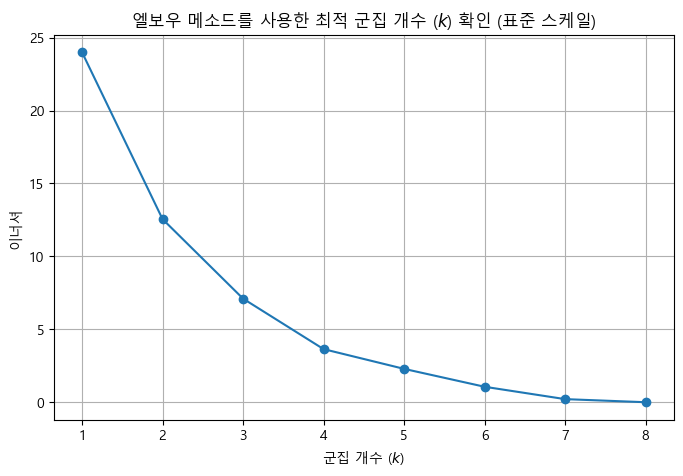

엘보우 그래프를 확인하여 최적의 군집 개수(k)를 결정하세요.
일반적으로 그래프의 꺾이는 지점(엘보우)이 최적의 k입니다. 시도된 k 범위: [1, 2, 3, 4, 5, 6, 7, 8]

가중치 적용 스케일링 데이터를 사용하여 엘보우 메소드 실행 중...


c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

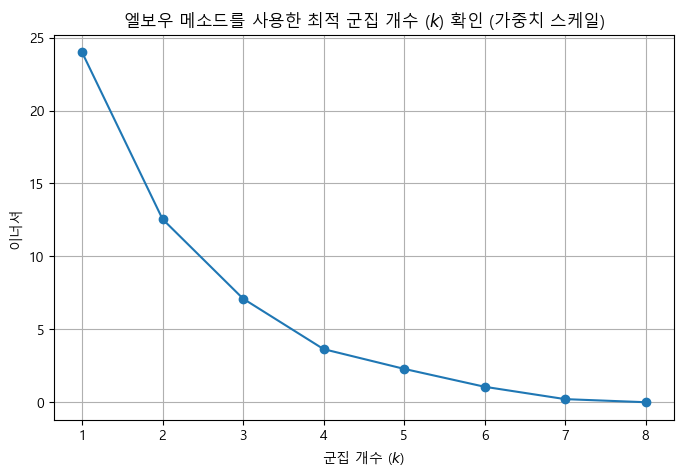

가중치 적용 엘보우 그래프를 확인하여 최적의 군집 개수(k)를 결정하세요.

--- 최종 군집화 실행 (선택된 k=4) ---
최종 군집화 완료 (표준 스케일).
------------------------------
--- 사용자별 최종 군집 결과 (표준 스케일) ---
  사용자 이름  당뇨병_등급  고혈압_등급  비만_등급  군집 라벨
0    홍길동       2       3      5      0
1    김철수       1       1      3      1
2    이영희       3       4      6      0
3    박철수       1       4      3      2
4    김민지       2       3      2      2
5    최영희       1       1      6      3
6    이지현       3       4      4      0
7    강우진       1       1      2      1

--- 군집별 특성 분석 (표준 스케일) ---

--- 군집별 평균 예측 등급 ---
각 군집에 속한 사용자들의 평균적인 질병 위험도입니다.
(값이 높을수록 해당 질병의 평균 위험도가 높음을 의미합니다)
--------------------------------------------------
         당뇨병_등급    고혈압_등급  비만_등급
군집 라벨                           
0      2.666667  3.666667    5.0
1      1.000000  1.000000    2.5
2      1.500000  3.500000    2.5
3      1.000000  1.000000    6.0
--------------------------------------------------

--- 군집 특성 해석 ---
▶ 군집 0 특징:
  - 당뇨병: 평균 2.67 등급 (주로 고위험군) (범위: 1-3)
  - 고혈압: 평균

c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [20]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- matplotlib 한글 폰트 설정 ---
# 시스템에 설치된 한글 폰트 경로를 찾아서 설정합니다.
# 보통 다음 폰트 중 하나는 대부분의 시스템에 설치되어 있습니다.
# Windows: Malgun Gothic
# macOS: AppleGothic
# Linux: NanumGothic (설치 필요할 수 있음)

plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
# 다른 폰트를 사용하고 싶다면 위 'Malgun Gothic' 대신 시스템에 설치된 다른 한글 폰트 이름으로 변경하세요.
# 예: plt.rcParams['font.family'] = 'AppleGothic' # macOS
# 예: plt.rcParams['font.family'] = 'NanumGothic' # 나눔고딕 (설치되어 있어야 함)

# 만약 위 설정으로도 한글이 깨진다면, 시스템에 해당 폰트가 없거나 경로 설정이 필요할 수 있습니다.
# 고급 설정 방법:
# from matplotlib import font_manager, rc
# font_path = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# font_name = font_manager.FontProperties(fname="폰트파일경로.ttf").get_name()
# rc('font', family=font_name)

# 마이너스 부호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False

# --- matplotlib 한글 폰트 설정 끝 ---


# --- 1. 상태 분류 기준 함수 (자동 분류용) ---
def classify_feature_status(feature_name, user_value):
    if feature_name == "HE_sbp1":
        if user_value <= 120: return "정상", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        elif 121 <= user_value <= 139: return "주의", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        else: return "고위험", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
    elif feature_name == "HE_glu":
        if user_value <= 99: return "정상", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        elif 100 <= user_value <= 125: return "주의", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        else: return "고위험", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
    elif feature_name == "HE_BMI":
        if user_value < 18.5: return "저체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        elif 18.5 <= user_value <= 22.9: return "정상", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        elif 23.0 <= user_value <= 24.9: return "과체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        else: return "비만", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
    else: return "Unknown", "-", "-"

# --- 사용자 입력 데이터 전처리 함수 ---
def process_user_input(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)
    user_scaled = scaler.transform(user_df)
    return user_df, user_scaled

# --- 예측 실행 함수 ---
def predict_disease_probabilities(user_scaled, model, stages, class_explanations):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    stage = stages.get(stage_index, "Unknown")
    explanation = class_explanations.get(stage_index, "No explanation available.")

    result = {
        "probabilities": probs.tolist(),
        "predicted_class": stage_index + 1,
        "class_name": stage,
        "explanation": explanation,
        "predicted_probability": probs[stage_index]
    }
    return result

# --- 2. 예측 결과를 종합해 리포트 생성 ---
def generate_disease_report(user_name, disease_name, prediction_result, top_feature_name, user_value):
    if not prediction_result:
        print(f"=== {disease_name} 예측 결과 ===")
        print("예측 결과를 생성할 수 없습니다.")
        print("-" * 30)
        return

    prob_percent = prediction_result.get('predicted_probability', 0.0) * 100
    health_score = round(prob_percent, 1)

    feature_label_map = {
        "HE_sbp1": "HE_sbp1 (수축기 혈압)",
        "HE_glu": "HE_glu (공복혈당)",
        "HE_BMI": "HE_BMI (BMI)"
    }
    feature_label = feature_label_map.get(top_feature_name, top_feature_name)

    status, normal_range, caution_range = classify_feature_status(top_feature_name, user_value)

    interpretation = ""
    if status == "정상" or status == "정상 체중":
         interpretation = f"이 수치는 현재 {disease_name}과 관련하여 양호한 상태를 나타냅니다."
    elif status in ["주의", "과체중"]:
         interpretation = f"이 수치는 {disease_name} 위험 증가에 대한 주의가 필요함을 시사합니다."
    elif status in ["고위험", "비만", "경도 비만", "중등도 비만", "고도 비만"]:
         interpretation = f"이 수치는 {disease_name} 발생 또는 악화와 밀접한 관련이 있으며, 적극적인 관리가 필요합니다."
    elif status == "저체중":
         interpretation = "이 수치는 저체중과 관련 있으며, 건강한 체중 증량 노력이 필요할 수 있습니다."
    else:
         interpretation = "이 수치에 대한 추가 정보가 필요합니다."

    print(f"=== {disease_name} 예측 결과 ===")
    print(f"1. {user_name}님의 {disease_name} 위험도는 '{prediction_result['class_name']}' ({prediction_result['predicted_class']}등급)입니다.")
    print(f"2. 건강 점수: {health_score:.1f}점 (예측 확률: {prob_percent:.1f}%)")
    print(f"설명: {prediction_result['explanation']}\n")

    print(f"3. 주요 관련 지표 ({feature_label}) 수치: {user_value} → 상태: {status}")
    print(f"   정상 기준: {normal_range}, 주의/고위험 기준: {caution_range}")
    print(f"   해석: {interpretation}")
    print("-" * 30)

# --- 3. 군집화 준비 (예측 결과 기반 feature vector 생성) ---
def create_cluster_vector(result_dm, result_hp, result_obesity):
    if not (result_dm and result_hp and result_obesity):
        return None
    cluster_vector = {
        "당뇨병_등급": result_dm.get('predicted_class', 0),
        "고혈압_등급": result_hp.get('predicted_class', 0),
        "비만_등급": result_obesity.get('predicted_class', 0)
    }
    return cluster_vector

# --- 4. (선택) 가중치 기반 클러스터링을 위한 벡터 생성 ---
def create_weighted_cluster_vector(cluster_vector, weights):
    if not cluster_vector:
        return None
    weighted_vector = {}
    for key, value in cluster_vector.items():
        weighted_vector[key] = value * weights.get(key, 1.0)
    return weighted_vector

# --- 군집 특성 분석 함수 ---
def analyze_cluster_characteristics(cluster_df_with_labels, grade_ranges):
    """
    각 군집의 예측 등급 평균을 계산하여 군집 특성을 분석합니다.
    군집 라벨이 포함된 DataFrame을 받아 그룹화하고 평균을 계산합니다.
    """
    if '군집 라벨' not in cluster_df_with_labels.columns:
         print("오류: '군집 라벨' 컬럼이 DataFrame에 없습니다.")
         return None

    cluster_centers = cluster_df_with_labels.groupby('군집 라벨').mean(numeric_only=True)

    print("\n--- 군집별 평균 예측 등급 ---")
    print("각 군집에 속한 사용자들의 평균적인 질병 위험도입니다.")
    print("(값이 높을수록 해당 질병의 평균 위험도가 높음을 의미합니다)")
    print("-" * 50)
    print(cluster_centers)
    print("-" * 50)

    print("\n--- 군집 특성 해석 ---")
    for cluster_id, center in cluster_centers.iterrows():
        print(f"▶ 군집 {cluster_id} 특징:")
        for col_name_korean, col_name_english in {
            '당뇨병': '당뇨병_등급',
            '고혈압': '고혈압_등급',
            '비만': '비만_등급'
        }.items():
            if col_name_english in center.index:
                 mean_grade = center[col_name_english]
                 grade_range_str = grade_ranges.get(col_name_english, "Unknown range")

                 interpretation = f"평균 {mean_grade:.2f} 등급"
                 if col_name_english == '당뇨병_등급':
                     if mean_grade < 1.5: interpretation += " (주로 정상)"
                     elif mean_grade < 2.5: interpretation += " (주로 주의 필요)"
                     else: interpretation += " (주로 고위험군)"
                 elif col_name_english == '고혈압_등급':
                  if mean_grade < 1.5: interpretation += " (주로 정상 혈압)"
                  elif mean_grade < 2.5: interpretation += " (주로 주의 혈압)"
                  elif mean_grade < 3.5: interpretation += " (주로 고혈압 1기)"
                  else: interpretation += " (주로 고혈압 2기)"
                 elif col_name_english == '비만_등급':
                     if mean_grade < 1.5: interpretation += " (주로 저체중)"
                     elif mean_grade < 2.5: interpretation += " (주로 정상 체중)"
                     elif mean_grade < 3.5: interpretation += " (주로 과체중/경도 비만)"
                     elif mean_grade < 4.5: interpretation += " (주로 경도 비만)"
                     elif mean_grade < 5.5: interpretation += " (주로 중등도 비만)"
                     else: interpretation += " (주로 고도 비만)"

                 print(f"  - {col_name_korean}: {interpretation} (범위: {grade_range_str})")
            else:
                 print(f"  - {col_name_korean}: 특성 분석 데이터에 포함되지 않음")

        print("-" * 20)
    return cluster_centers


# --- 메인 실행 로직 ---
if __name__ == "__main__":

    print("--- 모델 및 데이터 로딩 시작 ---")
    try:
        model_dm = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        scaler_dm = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        features_dm = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        train_means_dm = joblib.load('train_means_dm_real.pkl')

        model_hp = joblib.load('For_HE_HP_calibrated_real.pkl')
        scaler_hp = joblib.load('HE_HP_scaler_real.pkl')
        features_hp = joblib.load('HE_HP_input_features_list_real.pkl')
        train_means_hp = joblib.load('train_means_hp_real.pkl')

        model_obesity = joblib.load('For_HE_obe_calibrated_real.pkl')
        scaler_obesity = joblib.load('HE_obe_scaler_real.pkl')
        features_obesity = joblib.load('HE_obe_input_features_list_real.pkl')
        train_means_obesity = joblib.load('train_means_obe_real.pkl')

        print("모델 및 데이터 로딩 성공.")

    except FileNotFoundError as e:
        print(f"오류: 모델 또는 데이터 파일을 찾을 수 없습니다 - {e}")
        print("필요한 .pkl 파일들이 현재 디렉토리에 있는지 확인해주세요.")
        exit()
    except Exception as e:
        print(f"오류: 모델 로딩 중 예상치 못한 오류 발생 - {e}")
        exit()

    diabetes_stages = {0: "정상", 1: "주의 필요", 2: "고위험군"}
    diabetes_class_explanations = {
        0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
        1: "혈당이 정상보다 높은 수준이지만 당뇨병에는 이르지 않았습니다. 생활습관 개선이 필요합니다.",
        2: "당뇨병 고위험군으로 예측됩니다. 전문가와 상담 및 정밀 검사가 필요합니다."
    }

    hypertension_stages = {0: "정상 혈압", 1: "주의 혈압", 2: "고혈압 1기", 3: "고혈압 2기"}
    hypertension_class_explanations = {
        0: "혈압이 정상 범위에 있습니다. 건강한 생활 습관을 유지하세요.",
        1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
        2: "고혈압 1기 단계로 진단될 수 있는 혈압입니다. 의료 전문가와 상담이 필요합니다.",
        3: "혈압이 매우 높아 고혈압 2기 단계로 진단될 수 있습니다. 즉각적인 전문가의 진단과 치료가 필요합니다."
    }

    obesity_stages = {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "경도 비만", 4: "중등도 비만", 5: "고도 비만"}
    obesity_class_explanations = {
        0: "BMI가 낮아 저체중으로 분류됩니다. 건강한 체중 관리를 위해 전문가와 상담할 수 있습니다.",
        1: "BMI가 정상 범위입니다. 건강한 식습관과 운동을 통해 적정 체중을 유지하세요.",
        2: "BMI가 과체중 범위입니다. 체중 증가를 주의하고 건강한 생활 습관 개선을 시도하는 것이 좋습니다.",
        3: "BMI가 비만 기준에 속합니다. 체중 감량을 위한 적극적인 노력이 필요하며, 관련 질환 위험이 높아질 수 있습니다.",
        4: "BMI가 높아 중등도 비만에 해당합니다. 비만 관련 합병증 예방을 위해 전문가의 도움이 필요할 수 있습니다.",
        5: "BMI가 매우 높아 고도 비만에 해당합니다. 건강에 심각한 영향을 줄 수 있으므로, 전문적인 비만 치료 및 관리가 필수적입니다."
    }

    list_user_data = [
        { "user_name": "홍길동", 'HE_glu': 115.0, 'HE_HbA1c': 6.0, 'HE_ht': 170, 'HE_wt': 80, 'HE_wc': 100, 'HE_BMI': 27.68, 'HE_sbp1': 130, 'HE_dbp1': 85, 'HE_sbp2': 130, 'HE_dbp2': 80, 'HE_Upro': 7, 'HE_chol': 220, 'HE_HDL_st2': 50, 'HE_TG': 150, 'HE_LDL_drct': 130, 'HE_crea': 0.8, 'HE_ast': 20, 'HE_alt': 15, 'LS_FRUOT': 4 },
        { "user_name": "김철수", 'HE_glu': 90.0, 'HE_HbA1c': 5.5, 'HE_ht': 175, 'HE_wt': 70, 'HE_wc': 85, 'HE_BMI': 22.86, 'HE_sbp1': 110, 'HE_dbp1': 70, 'HE_sbp2': 105, 'HE_dbp2': 68, 'HE_Upro': 1, 'HE_chol': 180, 'HE_HDL_st2': 60, 'HE_TG': 100, 'HE_LDL_drct': 100, 'HE_crea': 0.9, 'HE_ast': 25, 'HE_alt': 20, 'LS_FRUOT': 5 },
        { "user_name": "이영희", 'HE_glu': 150.0, 'HE_HbA1c': 7.5, 'HE_ht': 160, 'HE_wt': 75, 'HE_wc': 110, 'HE_BMI': 29.30, 'HE_sbp1': 150, 'HE_dbp1': 95, 'HE_sbp2': 145, 'HE_dbp2': 90, 'HE_Upro': 7, 'HE_chol': 250, 'HE_HDL_st2': 40, 'HE_TG': 200, 'HE_LDL_drct': 160, 'HE_crea': 0.7, 'HE_ast': 30, 'HE_alt': 35, 'LS_FRUOT': 2 },
        { "user_name": "박철수", 'HE_glu': 95.0, 'HE_HbA1c': 5.8, 'HE_ht': 180, 'HE_wt': 78, 'HE_wc': 90, 'HE_BMI': 24.07, 'HE_sbp1': 165, 'HE_dbp1': 100, 'HE_sbp2': 160, 'HE_dbp2': 95, 'HE_Upro': 1, 'HE_chol': 200, 'HE_HDL_st2': 55, 'HE_TG': 120, 'HE_LDL_drct': 110, 'HE_crea': 1.1, 'HE_ast': 22, 'HE_alt': 18, 'LS_FRUOT': 3 },
        { "user_name": "김민지", 'HE_glu': 105.0, 'HE_HbA1c': 5.9, 'HE_ht': 165, 'HE_wt': 60, 'HE_wc': 80, 'HE_BMI': 22.04, 'HE_sbp1': 125, 'HE_dbp1': 80, 'HE_sbp2': 122, 'HE_dbp2': 78, 'HE_Upro': 1, 'HE_chol': 190, 'HE_HDL_st2': 58, 'HE_TG': 110, 'HE_LDL_drct': 105, 'HE_crea': 0.7, 'HE_ast': 18, 'HE_alt': 16, 'LS_FRUOT': 4 },
        { "user_name": "최영희", 'HE_glu': 92.0, 'HE_HbA1c': 5.6, 'HE_ht': 158, 'HE_wt': 95, 'HE_wc': 120, 'HE_BMI': 38.07, 'HE_sbp1': 118, 'HE_dbp1': 75, 'HE_sbp2': 115, 'HE_dbp2': 72, 'HE_Upro': 1, 'HE_chol': 230, 'HE_HDL_st2': 45, 'HE_TG': 180, 'HE_LDL_drct': 140, 'HE_crea': 0.6, 'HE_ast': 25, 'HE_alt': 22, 'LS_FRUOT': 2 },
        { "user_name": "이지현", 'HE_glu': 135.0, 'HE_HbA1c': 6.8, 'HE_ht': 170, 'HE_wt': 75, 'HE_wc': 95, 'HE_BMI': 25.95, 'HE_sbp1': 145, 'HE_dbp1': 90, 'HE_sbp2': 140, 'HE_dbp2': 88, 'HE_Upro': 1, 'HE_chol': 210, 'HE_HDL_st2': 52, 'HE_TG': 160, 'HE_LDL_drct': 135, 'HE_crea': 0.9, 'HE_ast': 28, 'HE_alt': 30, 'LS_FRUOT': 3 },
         { "user_name": "강우진", 'HE_glu': 85.0, 'HE_HbA1c': 5.2, 'HE_ht': 185, 'HE_wt': 70, 'HE_wc': 88, 'HE_BMI': 20.45, 'HE_sbp1': 105, 'HE_dbp1': 65, 'HE_sbp2': 100, 'HE_dbp2': 62, 'HE_Upro': 1, 'HE_chol': 170, 'HE_HDL_st2': 65, 'HE_TG': 90, 'HE_LDL_drct': 95, 'HE_crea': 1.0, 'HE_ast': 19, 'HE_alt': 17, 'LS_FRUOT': 5 },
    ]


    top_features = {
        "당뇨병": "HE_glu",
        "고혈압": "HE_sbp1",
        "비만": "HE_BMI"
    }

    all_user_vectors = []
    all_user_weighted_vectors = []
    user_names = []

    print("\n--- 사용자별 데이터 처리 및 예측 실행 ---")

    for user_data in list_user_data:
        user_name = user_data.get("user_name", "알 수 없는 사용자")
        user_names.append(user_name)

        # print(f"\n--- {user_name}님 데이터 처리 ---")

        user_df_dm, user_scaled_dm = process_user_input(user_data, features_dm, scaler_dm, train_means_dm)
        result_dm = predict_disease_probabilities(user_scaled_dm, model_dm, diabetes_stages, diabetes_class_explanations)

        user_df_hp, user_scaled_hp = process_user_input(user_data, features_hp, scaler_hp, train_means_hp)
        result_hp = predict_disease_probabilities(user_scaled_hp, model_hp, hypertension_stages, hypertension_class_explanations)

        user_df_obesity, user_scaled_obesity = process_user_input(user_data, features_obesity, scaler_obesity, train_means_obesity)
        result_obesity = predict_disease_probabilities(user_scaled_obesity, model_obesity, obesity_stages, obesity_class_explanations)

        user_cluster_vector = create_cluster_vector(result_dm, result_hp, result_obesity)

        if user_cluster_vector:
            all_user_vectors.append(user_cluster_vector)

            clustering_weights = {
                "당뇨병_등급": 2.0,
                "고혈압_등급": 1.2,
                "비만_등급": 1.0
            }
            user_weighted_cluster_vector = create_weighted_cluster_vector(user_cluster_vector, clustering_weights)
            if user_weighted_cluster_vector:
                 all_user_weighted_vectors.append(user_weighted_cluster_vector)


    print("\n--- 사용자별 데이터 처리 및 예측 완료 ---\n")

    print("--- 군집화 실행 준비 ---")

    if not all_user_vectors:
        print("오류: 군집화할 사용자 데이터가 없습니다.")
    else:
        cluster_df = pd.DataFrame(all_user_vectors)

        # --- 등급 컬럼을 명시적으로 숫자 타입으로 변환 ---
        grade_columns = ['당뇨병_등급', '고혈압_등급', '비만_등급']
        for col in grade_columns:
            if col in cluster_df.columns:
                cluster_df[col] = pd.to_numeric(cluster_df[col], errors='coerce')
            else:
                print(f"경고: 군집화 DataFrame에 컬럼 '{col}'이(가) 없습니다.")
        # 변환 후 발생할 수 있는 NaN은 여기서는 가정상 없을 것으로 처리

        # --- 벡터 스케일링 ---
        scaler_cluster = StandardScaler()
        cluster_scaled_df = pd.DataFrame(scaler_cluster.fit_transform(cluster_df[grade_columns]), columns=grade_columns)


        print("스케일링된 군집화 데이터를 사용하여 엘보우 메소드 실행 중...")

        k_range_max = min(len(all_user_vectors), 10)
        k_range = range(1, k_range_max + 1)
        inertia = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10 if k > 1 else 'auto')
            kmeans.fit(cluster_scaled_df)
            inertia.append(kmeans.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.title('엘보우 메소드를 사용한 최적 군집 개수 ($k$) 확인 (표준 스케일)')
        plt.xlabel('군집 개수 ($k$)')
        plt.ylabel('이너셔')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()

        print("엘보우 그래프를 확인하여 최적의 군집 개수(k)를 결정하세요.")
        print(f"일반적으로 그래프의 꺾이는 지점(엘보우)이 최적의 k입니다. 시도된 k 범위: {list(k_range)}")


        if all_user_weighted_vectors:
             print("\n가중치 적용 스케일링 데이터를 사용하여 엘보우 메소드 실행 중...")
             weighted_cluster_df = pd.DataFrame(all_user_weighted_vectors)

             # --- 가중치 적용 등급 컬럼을 명시적으로 숫자 타입으로 변환 ---
             weighted_grade_columns = ['당뇨병_등급', '고혈압_등급', '비만_등급']
             for col in weighted_grade_columns:
                  if col in weighted_cluster_df.columns:
                      weighted_cluster_df[col] = pd.to_numeric(weighted_cluster_df[col], errors='coerce')
                  else:
                      print(f"경고: 가중치 군집화 DataFrame에 컬럼 '{col}'이(가) 없습니다.")

             scaler_weighted_cluster = StandardScaler()
             weighted_cluster_scaled_df = pd.DataFrame(
                 scaler_weighted_cluster.fit_transform(weighted_cluster_df[weighted_grade_columns]),
                 columns=weighted_grade_columns
             )

             inertia_weighted = []
             for k in k_range:
                 kmeans_weighted = KMeans(n_clusters=k, random_state=42, n_init=10 if k > 1 else 'auto')
                 kmeans_weighted.fit(weighted_cluster_scaled_df)
                 inertia_weighted.append(kmeans_weighted.inertia_)

             plt.figure(figsize=(8, 5))
             plt.plot(k_range, inertia_weighted, marker='o')
             plt.title('엘보우 메소드를 사용한 최적 군집 개수 ($k$) 확인 (가중치 스케일)')
             plt.xlabel('군집 개수 ($k$)')
             plt.ylabel('이너셔')
             plt.xticks(k_range)
             plt.grid(True)
             plt.show()
             print("가중치 적용 엘보우 그래프를 확인하여 최적의 군집 개수(k)를 결정하세요.")


        # --- (사용자 결정 후) 선택된 k 값으로 최종 KMeans 적용 및 결과 출력 ---
        # 사용자가 위 그래프를 보고 직접 결정한 k 값을 여기에 입력하세요.
        chosen_n_clusters = 4 # <--- 엘보우 그래프를 보고 이 값을 변경하세요!
        print(f"\n--- 최종 군집화 실행 (선택된 k={chosen_n_clusters}) ---")

        # 표준 스케일 벡터로 최종 군집화
        kmeans_final = KMeans(n_clusters=chosen_n_clusters, random_state=42, n_init=10 if chosen_n_clusters > 1 else 'auto')
        cluster_labels = kmeans_final.fit_predict(cluster_scaled_df)

        print("최종 군집화 완료 (표준 스케일).")
        print("-" * 30)

        # --- 최종 군집 결과에 라벨 추가 및 특성 분석 ---
        results_summary_df = cluster_df.copy()
        results_summary_df['사용자 이름'] = user_names
        results_summary_df['군집 라벨'] = cluster_labels

        results_summary_df = results_summary_df[['사용자 이름'] + grade_columns + ['군집 라벨']]

        print("--- 사용자별 최종 군집 결과 (표준 스케일) ---")
        print(results_summary_df)

        # --- 군집별 특성 분석 (표준 스케일) ---
        print("\n--- 군집별 특성 분석 (표준 스케일) ---")
        grade_ranges = {
             "당뇨병_등급": "1-3",
             "고혈압_등급": "1-4",
             "비만_등급": "1-6"
        }
        standard_cluster_characteristics = analyze_cluster_characteristics(results_summary_df, grade_ranges)


        # 가중치 적용 스케일 벡터로 최종 군집화 (선택 사항)
        if all_user_weighted_vectors:
            print(f"\n--- 최종 군집화 실행 (선택된 k={chosen_n_clusters}, 가중치 적용) ---")
            kmeans_weighted_final = KMeans(n_clusters=chosen_n_clusters, random_state=42, n_init=10 if chosen_n_clusters > 1 else 'auto')
            weighted_cluster_labels = kmeans_weighted_final.fit_predict(weighted_cluster_scaled_df)

            print("최종 군집화 완료 (가중치 스케일).")
            print("-" * 30)

            weighted_results_summary_df = weighted_cluster_df.copy()
            weighted_results_summary_df['사용자 이름'] = user_names
            weighted_results_summary_df['가중치 적용 군집 라벨'] = weighted_cluster_labels

            weighted_results_summary_df = weighted_results_summary_df[['사용자 이름'] + weighted_grade_columns + ['가중치 적용 군집 라벨']]

            print("--- 사용자별 최종 군집 결과 (가중치 스케일) ---")
            print(weighted_results_summary_df)

            # --- 군집별 특성 분석 (가중치 스케일) ---
            weighted_analysis_df = weighted_results_summary_df.rename(columns={'가중치 적용 군집 라벨': '군집 라벨'})

            print("\n--- 군집별 특성 분석 (가중치 스케일) ---")
            weighted_cluster_characteristics = analyze_cluster_characteristics(weighted_analysis_df, grade_ranges)


    print("\n--- 전체 프로세스 완료 ---")

실루엣 점수 추가 

--- 모델 및 데이터 로딩 시작 ---
모델 및 데이터 로딩 성공.

--- 사용자별 데이터 처리 및 예측 실행 ---

--- 사용자별 데이터 처리 및 예측 완료 ---

--- 군집화 실행 준비 ---
스케일링된 군집화 데이터를 사용하여 엘보우 메소드 및 실루엣 점수 계산 중...


c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

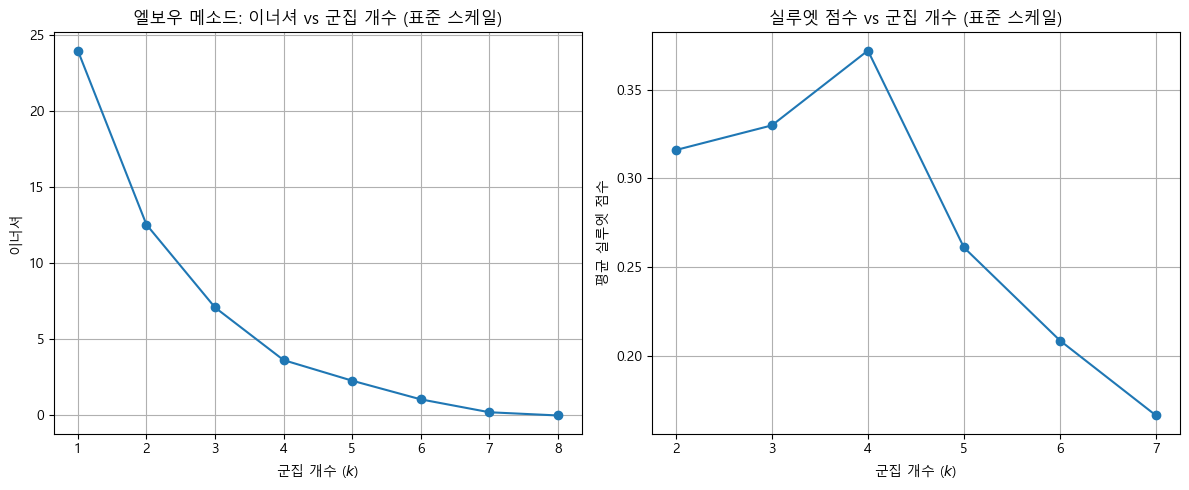

엘보우 그래프 (좌측)와 실루엣 점수 그래프 (우측)를 확인하여 최적의 군집 개수(k)를 결정하세요.
엘보우 그래프는 꺾이는 지점, 실루엣 점수 그래프는 가장 높은 지점을 참고합니다.
시도된 k 범위 (이너셔): [1, 2, 3, 4, 5, 6, 7, 8]
시도된 k 범위 (실루엣): [2, 3, 4, 5, 6, 7]

가중치 적용 스케일링 데이터를 사용하여 엘보우 메소드 및 실루엣 점수 계산 중...


c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

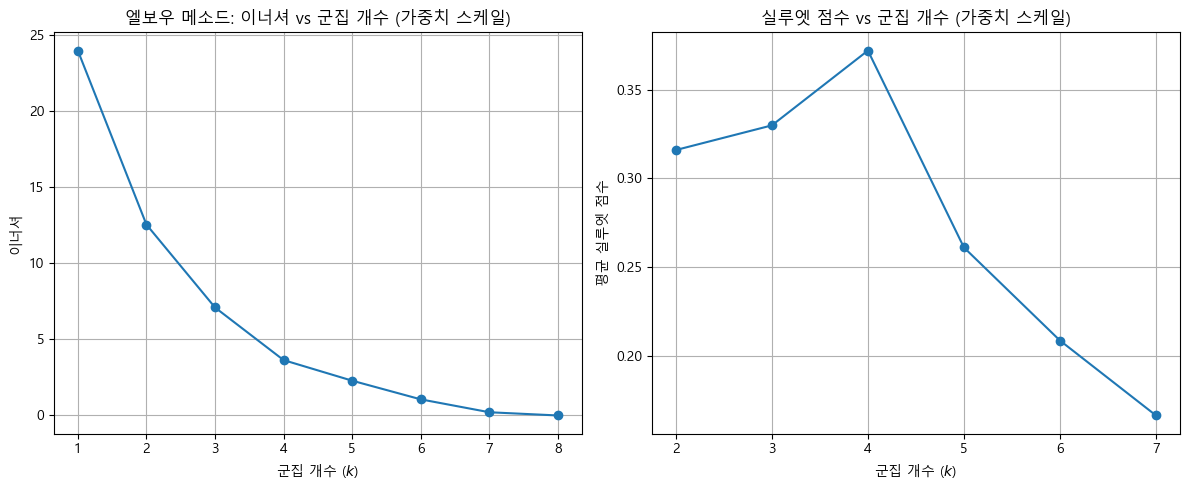

가중치 적용 엘보우 그래프 (좌측)와 실루엣 점수 그래프 (우측)를 확인하여 최적의 군집 개수(k)를 결정하세요.
시도된 k 범위 (실루엣): [2, 3, 4, 5, 6, 7]

--- 최종 군집화 실행 (선택된 k=4) ---
최종 군집화 완료 (표준 스케일).
------------------------------
--- 사용자별 최종 군집 결과 (표준 스케일) ---
  사용자 이름  당뇨병_등급  고혈압_등급  비만_등급  군집 라벨
0    홍길동       2       3      5      0
1    김철수       1       1      3      1
2    이영희       3       4      6      0
3    박철수       1       4      3      2
4    김민지       2       3      2      2
5    최영희       1       1      6      3
6    이지현       3       4      4      0
7    강우진       1       1      2      1

--- 군집별 특성 분석 (표준 스케일) ---

--- 군집별 평균 예측 등급 ---
각 군집에 속한 사용자들의 평균적인 질병 위험도입니다.
(값이 높을수록 해당 질병의 평균 위험도가 높음을 의미합니다)
--------------------------------------------------
         당뇨병_등급    고혈압_등급  비만_등급
군집 라벨                           
0      2.666667  3.666667    5.0
1      1.000000  1.000000    2.5
2      1.500000  3.500000    2.5
3      1.000000  1.000000    6.0
--------------------------------------------------

--- 군집 특성 해석 ---
▶ 군집 

c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [23]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # 실루엣 점수 계산 함수 임포트
import matplotlib.pyplot as plt

# --- matplotlib 한글 폰트 설정 ---
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# --- matplotlib 한글 폰트 설정 끝 ---


# --- 1. 상태 분류 기준 함수 (자동 분류용) ---
def classify_feature_status(feature_name, user_value):
    if feature_name == "HE_sbp1":
        if user_value <= 120: return "정상", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        elif 121 <= user_value <= 139: return "주의", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
        else: return "고위험", "90 ~ 120 mmHg", "121 ~ 139 mmHg"
    elif feature_name == "HE_glu":
        if user_value <= 99: return "정상", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        elif 100 <= user_value <= 125: return "주의", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
        else: return "고위험", "70 ~ 99 mg/dL", "100 ~ 125 mg/dL"
    elif feature_name == "HE_BMI":
        if user_value < 18.5: return "저체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        elif 18.5 <= user_value <= 22.9: return "정상", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        elif 23.0 <= user_value <= 24.9: return "과체중", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
        else: return "비만", "18.5 ~ 22.9 kg/m²", "23.0 ~ 24.9 kg/m² 이상"
    else: return "Unknown", "-", "-"

# --- 사용자 입력 데이터 전처리 함수 ---
def process_user_input(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)
    user_scaled = scaler.transform(user_df)
    return user_df, user_scaled

# --- 예측 실행 함수 ---
def predict_disease_probabilities(user_scaled, model, stages, class_explanations):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    stage = stages.get(stage_index, "Unknown")
    explanation = class_explanations.get(stage_index, "No explanation available.")

    result = {
        "probabilities": probs.tolist(),
        "predicted_class": stage_index + 1,
        "class_name": stage,
        "explanation": explanation,
        "predicted_probability": probs[stage_index]
    }
    return result

# --- 2. 예측 결과를 종합해 리포트 생성 ---
def generate_disease_report(user_name, disease_name, prediction_result, top_feature_name, user_value):
    if not prediction_result:
        print(f"=== {disease_name} 예측 결과 ===")
        print("예측 결과를 생성할 수 없습니다.")
        print("-" * 30)
        return

    prob_percent = prediction_result.get('predicted_probability', 0.0) * 100
    health_score = round(prob_percent, 1)

    feature_label_map = {
        "HE_sbp1": "HE_sbp1 (수축기 혈압)",
        "HE_glu": "HE_glu (공복혈당)",
        "HE_BMI": "HE_BMI (BMI)"
    }
    feature_label = feature_label_map.get(top_feature_name, top_feature_name)

    status, normal_range, caution_range = classify_feature_status(top_feature_name, user_value)

    interpretation = ""
    if status == "정상" or status == "정상 체중":
         interpretation = f"이 수치는 현재 {disease_name}과 관련하여 양호한 상태를 나타냅니다."
    elif status in ["주의", "과체중"]:
         interpretation = f"이 수치는 {disease_name} 위험 증가에 대한 주의가 필요함을 시사합니다."
    elif status in ["고위험", "비만", "경도 비만", "중등도 비만", "고도 비만"]:
         interpretation = f"이 수치는 {disease_name} 발생 또는 악화와 밀접한 관련이 있으며, 적극적인 관리가 필요합니다."
    elif status == "저체중":
         interpretation = "이 수치는 저체중과 관련 있으며, 건강한 체중 증량 노력이 필요할 수 있습니다."
    else:
         interpretation = "이 수치에 대한 추가 정보가 필요합니다."

    print(f"=== {disease_name} 예측 결과 ===")
    print(f"1. {user_name}님의 {disease_name} 위험도는 '{prediction_result['class_name']}' ({prediction_result['predicted_class']}등급)입니다.")
    print(f"2. 건강 점수: {health_score:.1f}점 (예측 확률: {prob_percent:.1f}%)")
    print(f"설명: {prediction_result['explanation']}\n")

    print(f"3. 주요 관련 지표 ({feature_label}) 수치: {user_value} → 상태: {status}")
    print(f"   정상 기준: {normal_range}, 주의/고위험 기준: {caution_range}")
    print(f"   해석: {interpretation}")
    print("-" * 30)

# --- 3. 군집화 준비 (예측 결과 기반 feature vector 생성) ---
def create_cluster_vector(result_dm, result_hp, result_obesity):
    if not (result_dm and result_hp and result_obesity):
        return None
    cluster_vector = {
        "당뇨병_등급": result_dm.get('predicted_class', 0),
        "고혈압_등급": result_hp.get('predicted_class', 0),
        "비만_등급": result_obesity.get('predicted_class', 0)
    }
    return cluster_vector

# --- 4. (선택) 가중치 기반 클러스터링을 위한 벡터 생성 ---
def create_weighted_cluster_vector(cluster_vector, weights):
    if not cluster_vector:
        return None
    weighted_vector = {}
    for key, value in cluster_vector.items():
        weighted_vector[key] = value * weights.get(key, 1.0)
    return weighted_vector

# --- 군집 특성 분석 함수 ---
def analyze_cluster_characteristics(cluster_df_with_labels, grade_ranges):
    """
    각 군집의 예측 등급 평균을 계산하여 군집 특성을 분석합니다.
    군집 라벨이 포함된 DataFrame을 받아 그룹화하고 평균을 계산합니다.
    """
    if '군집 라벨' not in cluster_df_with_labels.columns:
         print("오류: '군집 라벨' 컬럼이 DataFrame에 없습니다.")
         return None

    cluster_centers = cluster_df_with_labels.groupby('군집 라벨').mean(numeric_only=True)

    print("\n--- 군집별 평균 예측 등급 ---")
    print("각 군집에 속한 사용자들의 평균적인 질병 위험도입니다.")
    print("(값이 높을수록 해당 질병의 평균 위험도가 높음을 의미합니다)")
    print("-" * 50)
    print(cluster_centers)
    print("-" * 50)

    print("\n--- 군집 특성 해석 ---")
    for cluster_id, center in cluster_centers.iterrows():
        print(f"▶ 군집 {cluster_id} 특징:")
        for col_name_korean, col_name_english in {
            '당뇨병': '당뇨병_등급',
            '고혈압': '고혈압_등급',
            '비만': '비만_등급'
        }.items():
            if col_name_english in center.index:
                 mean_grade = center[col_name_english]
                 grade_range_str = grade_ranges.get(col_name_english, "Unknown range")

                 interpretation = f"평균 {mean_grade:.2f} 등급"
                 if col_name_english == '당뇨병_등급':
                     if mean_grade < 1.5: interpretation += " (주로 정상)"
                     elif mean_grade < 2.5: interpretation += " (주로 주의 필요)"
                     else: interpretation += " (주로 고위험군)"
                 elif col_name_english == '고혈압_등급':
                  if mean_grade < 1.5: interpretation += " (주로 정상 혈압)"
                  elif mean_grade < 2.5: interpretation += " (주로 주의 혈압)"
                  elif mean_grade < 3.5: interpretation += " (주로 고혈압 1기)"
                  else: interpretation += " (주로 고혈압 2기)"
                 elif col_name_english == '비만_등급':
                     if mean_grade < 1.5: interpretation += " (주로 저체중)"
                     elif mean_grade < 2.5: interpretation += " (주로 정상 체중)"
                     elif mean_grade < 3.5: interpretation += " (주로 과체중/경도 비만)"
                     elif mean_grade < 4.5: interpretation += " (주로 경도 비만)"
                     elif mean_grade < 5.5: interpretation += " (주로 중등도 비만)"
                     else: interpretation += " (주로 고도 비만)"

                 print(f"  - {col_name_korean}: {interpretation} (범위: {grade_range_str})")
            else:
                 print(f"  - {col_name_korean}: 특성 분석 데이터에 포함되지 않음")

        print("-" * 20)
    return cluster_centers


# --- 메인 실행 로직 ---
if __name__ == "__main__":

    print("--- 모델 및 데이터 로딩 시작 ---")
    try:
        model_dm = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        scaler_dm = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        features_dm = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        train_means_dm = joblib.load('train_means_dm_real.pkl')

        model_hp = joblib.load('For_HE_HP_calibrated_real.pkl')
        scaler_hp = joblib.load('HE_HP_scaler_real.pkl')
        features_hp = joblib.load('HE_HP_input_features_list_real.pkl')
        train_means_hp = joblib.load('train_means_hp_real.pkl')

        model_obesity = joblib.load('For_HE_obe_calibrated_real.pkl')
        scaler_obesity = joblib.load('HE_obe_scaler_real.pkl')
        features_obesity = joblib.load('HE_obe_input_features_list_real.pkl')
        train_means_obesity = joblib.load('train_means_obe_real.pkl')

        print("모델 및 데이터 로딩 성공.")

    except FileNotFoundError as e:
        print(f"오류: 모델 또는 데이터 파일을 찾을 수 없습니다 - {e}")
        print("필요한 .pkl 파일들이 현재 디렉토리에 있는지 확인해주세요.")
        exit()
    except Exception as e:
        print(f"오류: 모델 로딩 중 예상치 못한 오류 발생 - {e}")
        exit()

    diabetes_stages = {0: "정상", 1: "주의 필요", 2: "고위험군"}
    diabetes_class_explanations = {
        0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
        1: "혈당이 정상보다 높은 수준이지만 당뇨병에는 이르지 않았습니다. 생활습관 개선이 필요합니다.",
        2: "당뇨병 고위험군으로 예측됩니다. 전문가와 상담 및 정밀 검사가 필요합니다."
    }

    hypertension_stages = {0: "정상 혈압", 1: "주의 혈압", 2: "고혈압 1기", 3: "고혈압 2기"}
    hypertension_class_explanations = {
        0: "혈압이 정상 범위에 있습니다. 건강한 생활 습관을 유지하세요.",
        1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
        2: "고혈압 1기 단계로 진단될 수 있는 혈압입니다. 의료 전문가와 상담이 필요합니다.",
        3: "혈압이 매우 높아 고혈압 2기 단계로 진단될 수 있습니다. 즉각적인 전문가의 진단과 치료가 필요합니다."
    }

    obesity_stages = {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "경도 비만", 4: "중등도 비만", 5: "고도 비만"}
    obesity_class_explanations = {
        0: "BMI가 낮아 저체중으로 분류됩니다. 건강한 체중 관리를 위해 전문가와 상담할 수 있습니다.",
        1: "BMI가 정상 범위입니다. 건강한 식습관과 운동을 통해 적정 체중을 유지하세요.",
        2: "BMI가 과체중 범위입니다. 체중 증가를 주의하고 건강한 생활 습관 개선을 시도하는 것이 좋습니다.",
        3: "BMI가 비만 기준에 속합니다. 체중 감량을 위한 적극적인 노력이 필요하며, 관련 질환 위험이 높아질 수 있습니다.",
        4: "BMI가 높아 중등도 비만에 해당합니다. 비만 관련 합병증 예방을 위해 전문가의 도움이 필요할 수 있습니다.",
        5: "BMI가 매우 높아 고도 비만에 해당합니다. 건강에 심각한 영향을 줄 수 있으므로, 전문적인 비만 치료 및 관리가 필수적입니다."
    }

    list_user_data = [
        { "user_name": "홍길동", 'HE_glu': 115.0, 'HE_HbA1c': 6.0, 'HE_ht': 170, 'HE_wt': 80, 'HE_wc': 100, 'HE_BMI': 27.68, 'HE_sbp1': 130, 'HE_dbp1': 85, 'HE_sbp2': 130, 'HE_dbp2': 80, 'HE_Upro': 7, 'HE_chol': 220, 'HE_HDL_st2': 50, 'HE_TG': 150, 'HE_LDL_drct': 130, 'HE_crea': 0.8, 'HE_ast': 20, 'HE_alt': 15, 'LS_FRUOT': 4 },
        { "user_name": "김철수", 'HE_glu': 90.0, 'HE_HbA1c': 5.5, 'HE_ht': 175, 'HE_wt': 70, 'HE_wc': 85, 'HE_BMI': 22.86, 'HE_sbp1': 110, 'HE_dbp1': 70, 'HE_sbp2': 105, 'HE_dbp2': 68, 'HE_Upro': 1, 'HE_chol': 180, 'HE_HDL_st2': 60, 'HE_TG': 100, 'HE_LDL_drct': 100, 'HE_crea': 0.9, 'HE_ast': 25, 'HE_alt': 20, 'LS_FRUOT': 5 },
        { "user_name": "이영희", 'HE_glu': 150.0, 'HE_HbA1c': 7.5, 'HE_ht': 160, 'HE_wt': 75, 'HE_wc': 110, 'HE_BMI': 29.30, 'HE_sbp1': 150, 'HE_dbp1': 95, 'HE_sbp2': 145, 'HE_dbp2': 90, 'HE_Upro': 7, 'HE_chol': 250, 'HE_HDL_st2': 40, 'HE_TG': 200, 'HE_LDL_drct': 160, 'HE_crea': 0.7, 'HE_ast': 30, 'HE_alt': 35, 'LS_FRUOT': 2 },
        { "user_name": "박철수", 'HE_glu': 95.0, 'HE_HbA1c': 5.8, 'HE_ht': 180, 'HE_wt': 78, 'HE_wc': 90, 'HE_BMI': 24.07, 'HE_sbp1': 165, 'HE_dbp1': 100, 'HE_sbp2': 160, 'HE_dbp2': 95, 'HE_Upro': 1, 'HE_chol': 200, 'HE_HDL_st2': 55, 'HE_TG': 120, 'HE_LDL_drct': 110, 'HE_crea': 1.1, 'HE_ast': 22, 'HE_alt': 18, 'LS_FRUOT': 3 },
        { "user_name": "김민지", 'HE_glu': 105.0, 'HE_HbA1c': 5.9, 'HE_ht': 165, 'HE_wt': 60, 'HE_wc': 80, 'HE_BMI': 22.04, 'HE_sbp1': 125, 'HE_dbp1': 80, 'HE_sbp2': 122, 'HE_dbp2': 78, 'HE_Upro': 1, 'HE_chol': 190, 'HE_HDL_st2': 58, 'HE_TG': 110, 'HE_LDL_drct': 105, 'HE_crea': 0.7, 'HE_ast': 18, 'HE_alt': 16, 'LS_FRUOT': 4 },
        { "user_name": "최영희", 'HE_glu': 92.0, 'HE_HbA1c': 5.6, 'HE_ht': 158, 'HE_wt': 95, 'HE_wc': 120, 'HE_BMI': 38.07, 'HE_sbp1': 118, 'HE_dbp1': 75, 'HE_sbp2': 115, 'HE_dbp2': 72, 'HE_Upro': 1, 'HE_chol': 230, 'HE_HDL_st2': 45, 'HE_TG': 180, 'HE_LDL_drct': 140, 'HE_crea': 0.6, 'HE_ast': 25, 'HE_alt': 22, 'LS_FRUOT': 2 },
        { "user_name": "이지현", 'HE_glu': 135.0, 'HE_HbA1c': 6.8, 'HE_ht': 170, 'HE_wt': 75, 'HE_wc': 95, 'HE_BMI': 25.95, 'HE_sbp1': 145, 'HE_dbp1': 90, 'HE_sbp2': 140, 'HE_dbp2': 88, 'HE_Upro': 1, 'HE_chol': 210, 'HE_HDL_st2': 52, 'HE_TG': 160, 'HE_LDL_drct': 135, 'HE_crea': 0.9, 'HE_ast': 28, 'HE_alt': 30, 'LS_FRUOT': 3 },
         { "user_name": "강우진", 'HE_glu': 85.0, 'HE_HbA1c': 5.2, 'HE_ht': 185, 'HE_wt': 70, 'HE_wc': 88, 'HE_BMI': 20.45, 'HE_sbp1': 105, 'HE_dbp1': 65, 'HE_sbp2': 100, 'HE_dbp2': 62, 'HE_Upro': 1, 'HE_chol': 170, 'HE_HDL_st2': 65, 'HE_TG': 90, 'HE_LDL_drct': 95, 'HE_crea': 1.0, 'HE_ast': 19, 'HE_alt': 17, 'LS_FRUOT': 5 },
    ]


    top_features = {
        "당뇨병": "HE_glu",
        "고혈압": "HE_sbp1",
        "비만": "HE_BMI"
    }

    all_user_vectors = []
    all_user_weighted_vectors = []
    user_names = []

    print("\n--- 사용자별 데이터 처리 및 예측 실행 ---")

    for user_data in list_user_data:
        user_name = user_data.get("user_name", "알 수 없는 사용자")
        user_names.append(user_name)

        # print(f"\n--- {user_name}님 데이터 처리 ---")

        user_df_dm, user_scaled_dm = process_user_input(user_data, features_dm, scaler_dm, train_means_dm)
        result_dm = predict_disease_probabilities(user_scaled_dm, model_dm, diabetes_stages, diabetes_class_explanations)

        user_df_hp, user_scaled_hp = process_user_input(user_data, features_hp, scaler_hp, train_means_hp)
        result_hp = predict_disease_probabilities(user_scaled_hp, model_hp, hypertension_stages, hypertension_class_explanations)

        user_df_obesity, user_scaled_obesity = process_user_input(user_data, features_obesity, scaler_obesity, train_means_obesity)
        result_obesity = predict_disease_probabilities(user_scaled_obesity, model_obesity, obesity_stages, obesity_class_explanations)

        user_cluster_vector = create_cluster_vector(result_dm, result_hp, result_obesity)

        if user_cluster_vector:
            all_user_vectors.append(user_cluster_vector)

            clustering_weights = {
                "당뇨병_등급": 2.0,
                "고혈압_등급": 1.2,
                "비만_등급": 1.0
            }
            user_weighted_cluster_vector = create_weighted_cluster_vector(user_cluster_vector, clustering_weights)
            if user_weighted_cluster_vector:
                 all_user_weighted_vectors.append(user_weighted_cluster_vector)


    print("\n--- 사용자별 데이터 처리 및 예측 완료 ---\n")

    print("--- 군집화 실행 준비 ---")

    if not all_user_vectors:
        print("오류: 군집화할 사용자 데이터가 없습니다.")
    else:
        cluster_df = pd.DataFrame(all_user_vectors)

        # --- 등급 컬럼을 명시적으로 숫자 타입으로 변환 ---
        grade_columns = ['당뇨병_등급', '고혈압_등급', '비만_등급']
        for col in grade_columns:
            if col in cluster_df.columns:
                cluster_df[col] = pd.to_numeric(cluster_df[col], errors='coerce')
            else:
                print(f"경고: 군집화 DataFrame에 컬럼 '{col}'이(가) 없습니다.")
        # 변환 후 발생할 수 있는 NaN은 여기서는 가정상 없을 것으로 처리

        # --- 벡터 스케일링 ---
        scaler_cluster = StandardScaler()
        cluster_scaled_df = pd.DataFrame(scaler_cluster.fit_transform(cluster_df[grade_columns]), columns=grade_columns)


        print("스케일링된 군집화 데이터를 사용하여 엘보우 메소드 및 실루엣 점수 계산 중...")

        n_samples = len(all_user_vectors) # 총 사용자 수 (샘플 수)
        k_range_max = min(n_samples, 10) # 시도할 k의 최대값 (샘플 수 또는 10 중 작은 값)

        # 이너셔는 k=1부터 계산
        k_for_inertia = range(1, k_range_max + 1)
        inertia = []

        # 실루엣 점수는 k=2부터 n_samples-1까지 계산 가능
        # 만약 n_samples < 3 이면 실루엣 점수 계산 불가능
        if n_samples >= 3:
            k_range_for_silhouette = range(2, n_samples) # k=2 부터 n_samples-1 까지
            silhouette_scores = []
        else:
            k_range_for_silhouette = [] # 실루엣 점수 계산 범위 없음
            silhouette_scores = []
            print(f"경고: 실루엣 점수 계산에 필요한 최소 샘플 수(3개)가 충족되지 않았습니다 (현재 {n_samples}개).")


        for k in k_for_inertia:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10 if k > 1 else 'auto')
            kmeans.fit(cluster_scaled_df)
            inertia.append(kmeans.inertia_) # 이너셔는 k=1부터 계산

            # 실루엣 점수는 k가 유효 범위 [2, n_samples-1]에 있을 때만 계산
            if k in k_range_for_silhouette:
                 score = silhouette_score(cluster_scaled_df, kmeans.labels_)
                 silhouette_scores.append(score)


        # --- 엘보우 그래프 출력 ---
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(k_for_inertia, inertia, marker='o')
        plt.title('엘보우 메소드: 이너셔 vs 군집 개수 (표준 스케일)')
        plt.xlabel('군집 개수 ($k$)')
        plt.ylabel('이너셔')
        plt.xticks(k_for_inertia)
        plt.grid(True)

        # --- 실루엣 점수 그래프 출력 ---
        plt.subplot(1, 2, 2)
        # 실루엣 점수 그래프의 x축은 실루엣 점수가 계산된 실제 k 값 범위
        if silhouette_scores: # 실루엣 점수가 계산되었을 때만 그래프 그림
             plt.plot(k_range_for_silhouette, silhouette_scores, marker='o')
             plt.title('실루엣 점수 vs 군집 개수 (표준 스케일)')
             plt.xlabel('군집 개수 ($k$)')
             plt.ylabel('평균 실루엣 점수')
             plt.xticks(k_range_for_silhouette)
             plt.grid(True)
        else:
             plt.title('실루엣 점수 (표준 스케일)')
             plt.text(0.5, 0.5, '실루엣 점수 계산 불가 (샘플 부족)',
                      horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


        plt.tight_layout()
        plt.show()

        print("엘보우 그래프 (좌측)와 실루엣 점수 그래프 (우측)를 확인하여 최적의 군집 개수(k)를 결정하세요.")
        print("엘보우 그래프는 꺾이는 지점, 실루엣 점수 그래프는 가장 높은 지점을 참고합니다.")
        print(f"시도된 k 범위 (이너셔): {list(k_for_inertia)}")
        if silhouette_scores:
            print(f"시도된 k 범위 (실루엣): {list(k_range_for_silhouette)}")
        else:
            print("실루엣 점수 계산 범위: 실루엣 점수 계산에 필요한 샘플 수가 부족합니다.")


        if all_user_weighted_vectors:
             print("\n가중치 적용 스케일링 데이터를 사용하여 엘보우 메소드 및 실루엣 점수 계산 중...")
             weighted_cluster_df = pd.DataFrame(all_user_weighted_vectors)

             # --- 가중치 적용 등급 컬럼을 명시적으로 숫자 타입으로 변환 ---
             weighted_grade_columns = ['당뇨병_등급', '고혈압_등급', '비만_등급']
             for col in weighted_grade_columns:
                  if col in weighted_cluster_df.columns:
                      weighted_cluster_df[col] = pd.to_numeric(weighted_cluster_df[col], errors='coerce')
                  else:
                      print(f"경고: 가중치 군집화 DataFrame에 컬럼 '{col}'이(가) 없습니다.")

             scaler_weighted_cluster = StandardScaler()
             weighted_cluster_scaled_df = pd.DataFrame(
                 scaler_weighted_cluster.fit_transform(weighted_cluster_df[weighted_grade_columns]),
                 columns=weighted_grade_columns
             )

             inertia_weighted = []
             silhouette_scores_weighted = []

             if n_samples >= 3:
                 k_range_for_silhouette_weighted = range(2, n_samples) # k=2 부터 n_samples-1 까지
             else:
                 k_range_for_silhouette_weighted = []


             for k in k_for_inertia:
                 kmeans_weighted = KMeans(n_clusters=k, random_state=42, n_init=10 if k > 1 else 'auto')
                 kmeans_weighted.fit(weighted_cluster_scaled_df)
                 inertia_weighted.append(kmeans_weighted.inertia_)

                 if k in k_range_for_silhouette_weighted: # 실루엣 점수는 k가 유효 범위에 있을 때만 계산
                     score_weighted = silhouette_score(weighted_cluster_scaled_df, kmeans_weighted.labels_)
                     silhouette_scores_weighted.append(score_weighted)


             # --- 가중치 적용 엘보우 그래프 출력 ---
             plt.figure(figsize=(12, 5))

             plt.subplot(1, 2, 1)
             plt.plot(k_for_inertia, inertia_weighted, marker='o')
             plt.title('엘보우 메소드: 이너셔 vs 군집 개수 (가중치 스케일)')
             plt.xlabel('군집 개수 ($k$)')
             plt.ylabel('이너셔')
             plt.xticks(k_for_inertia)
             plt.grid(True)

             # --- 가중치 적용 실루엣 점수 그래프 출력 ---
             plt.subplot(1, 2, 2)
             if silhouette_scores_weighted: # 실루엣 점수가 계산되었을 때만 그래프 그림
                 plt.plot(k_range_for_silhouette_weighted, silhouette_scores_weighted, marker='o')
                 plt.title('실루엣 점수 vs 군집 개수 (가중치 스케일)')
                 plt.xlabel('군집 개수 ($k$)')
                 plt.ylabel('평균 실루엣 점수')
                 plt.xticks(k_range_for_silhouette_weighted)
                 plt.grid(True)
             else:
                 plt.title('실루엣 점수 (가중치 스케일)')
                 plt.text(0.5, 0.5, '실루엣 점수 계산 불가 (샘플 부족)',
                          horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

             plt.tight_layout()
             plt.show()

             print("가중치 적용 엘보우 그래프 (좌측)와 실루엣 점수 그래프 (우측)를 확인하여 최적의 군집 개수(k)를 결정하세요.")
             if silhouette_scores_weighted:
                 print(f"시도된 k 범위 (실루엣): {list(k_range_for_silhouette_weighted)}")
             else:
                 print("실루엣 점수 계산 범위: 실루엣 점수 계산에 필요한 샘플 수가 부족합니다.")


        # --- (사용자 결정 후) 선택된 k 값으로 최종 KMeans 적용 및 결과 출력 ---
        # 사용자가 위 그래프들을 보고 직접 결정한 k 값을 여기에 입력하세요.
        # 만약 엘보우나 실루엣 그래프에서 꺾이거나 가장 높은 지점을 찾기 어렵다면 (샘플 수가 적을 때 흔함),
        # 2 또는 3과 같은 작은 k 값부터 시작해보고 해석해보는 것도 방법입니다.
        chosen_n_clusters = 4 # <--- 엘보우 그래프와 실루엣 점수 그래프를 보고 이 값을 변경하세요!

        # chosen_n_clusters가 유효한 범위 [2, n_samples] 안에 있는지 확인 (최소 2개 군집부터 의미)
        if chosen_n_clusters < 2 or chosen_n_clusters > n_samples:
             print(f"\n경고: 선택된 군집 개수 k={chosen_n_clusters}가 유효 범위를 벗어납니다. (유효 범위: 2 ~ {n_samples})")
             # 기본값 2 또는 n_samples 중 작은 값으로 설정하거나, 사용자에게 재입력 요청 로직 추가 가능
             chosen_n_clusters = min(max(2, chosen_n_clusters), n_samples)
             print(f"군집 개수를 {chosen_n_clusters}로 조정하여 진행합니다.")
        elif n_samples == 1 and chosen_n_clusters > 1:
             print(f"\n경고: 샘플이 1개 뿐이므로 군집 개수를 1로 설정합니다.")
             chosen_n_clusters = 1


        print(f"\n--- 최종 군집화 실행 (선택된 k={chosen_n_clusters}) ---")

        if chosen_n_clusters >= 1: # 최소 1개 군집은 가능
            # 표준 스케일 벡터로 최종 군집화
            kmeans_final = KMeans(n_clusters=chosen_n_clusters, random_state=42, n_init=10 if chosen_n_clusters > 1 else 'auto')
            cluster_labels = kmeans_final.fit_predict(cluster_scaled_df)

            print("최종 군집화 완료 (표준 스케일).")
            print("-" * 30)

            # --- 최종 군집 결과에 라벨 추가 및 특성 분석 ---
            results_summary_df = cluster_df.copy()
            results_summary_df['사용자 이름'] = user_names
            results_summary_df['군집 라벨'] = cluster_labels

            results_summary_df = results_summary_df[['사용자 이름'] + grade_columns + ['군집 라벨']]

            print("--- 사용자별 최종 군집 결과 (표준 스케일) ---")
            print(results_summary_df)

            # 군집 특성 분석은 군집 개수가 2 이상일 때만 유의미
            if chosen_n_clusters >= 2:
                print("\n--- 군집별 특성 분석 (표준 스케일) ---")
                grade_ranges = {
                     "당뇨병_등급": "1-3",
                     "고혈압_등급": "1-4",
                     "비만_등급": "1-6"
                }
                standard_cluster_characteristics = analyze_cluster_characteristics(results_summary_df, grade_ranges)
            else:
                 print("\n군집 개수가 1개이므로 군집별 특성 분석은 수행하지 않습니다.")


            # 가중치 적용 스케일 벡터로 최종 군집화 (선택 사항)
            if all_user_weighted_vectors:
                print(f"\n--- 최종 군집화 실행 (선택된 k={chosen_n_clusters}, 가중치 적용) ---")
                # n_init='auto'는 k=1일 때만 유효, k>1이면 숫자로 명시해야 함.
                # chosen_n_clusters가 1보다 크면 10, 1이면 'auto' 사용
                kmeans_weighted_final = KMeans(n_clusters=chosen_n_clusters, random_state=42, n_init=10 if chosen_n_clusters > 1 else 'auto')
                weighted_cluster_labels = kmeans_weighted_final.fit_predict(weighted_cluster_scaled_df)

                print("최종 군집화 완료 (가중치 스케일).")
                print("-" * 30)

                weighted_results_summary_df = weighted_cluster_df.copy()
                weighted_results_summary_df['사용자 이름'] = user_names
                weighted_results_summary_df['가중치 적용 군집 라벨'] = weighted_cluster_labels

                weighted_results_summary_df = weighted_results_summary_df[['사용자 이름'] + weighted_grade_columns + ['가중치 적용 군집 라벨']]

                print("--- 사용자별 최종 군집 결과 (가중치 스케일) ---")
                print(weighted_results_summary_df)

                if chosen_n_clusters >= 2:
                    # --- 군집별 특성 분석 (가중치 스케일) ---
                    weighted_analysis_df = weighted_results_summary_df.rename(columns={'가중치 적용 군집 라벨': '군집 라벨'})
                    print("\n--- 군집별 특성 분석 (가중치 스케일) ---")
                    weighted_cluster_characteristics = analyze_cluster_characteristics(weighted_analysis_df, grade_ranges)
                else:
                     print("\n군집 개수가 1개이므로 가중치 적용 군집별 특성 분석은 수행하지 않습니다.")

        else:
            print(f"\n오류: 선택된 군집 개수 k={chosen_n_clusters}가 1보다 작습니다. 군집 개수는 최소 1 이상이어야 합니다.")


    print("\n--- 전체 프로세스 완료 ---")

생활습관 변수 추가 : 